In [1]:
# import common lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# import classifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

In [2]:
# active seaborn theme for matplotlib
sns.set_theme()

In [ ]:
# định nghĩa common function
def visualize_data(data):
    #data_len = len(data[data.columns[0]])
    #feature_len = data.columns.size - 1
    dumyx = np.full(len(data[data.columns[0]]), 0)

    # Create a figure
    plt.figure(figsize=(16, 35))

    for col in range(data.columns.size):
        plt.subplot(9, 6, col+1).set_title(data.columns[col])
        plt.scatter(dumyx, data.iloc[:,col])
        plt.tight_layout()

    plt.show()

def visualize_histogram(data, feature, max_cnt=None, min_dvt=None):
    plt.figure(figsize=(16, 5))
    
    counts, bin_edges = np.histogram(data[feature], bins=50, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    derivative_counts = np.gradient(counts, bin_centers[1] - bin_centers[0])

    plt.subplot(1, 2, 1).set_title(f"{feature} count")
    if max_cnt is not None:
        plt.ylim(0, max_cnt)
    plt.bar(bin_centers, counts, width=bin_centers[1] - bin_centers[0], edgecolor='black')

    plt.subplot(1, 2, 2).set_title(f"{feature} derivative")
    if min_dvt is not None:
        plt.ylim(min_dvt, 0)
    plt.plot(bin_centers, derivative_counts, linestyle='-')

    plt.show()

1. Load dataset

In [16]:
df1 = pd.read_csv('./open-meteo.2000-2009.csv')
df2 = pd.read_csv('./open-meteo.2010-2019.csv')
df3 = pd.read_csv('./open-meteo.2020-2025.csv')

data = pd.concat([df1, df2, df3])

In [17]:
print(f"column count {data.columns.size}")
print(f"row count count {data.size}")
print(f"feature list: {data.columns}")
print("sample 1 row:")
print(data[0:1])

column count 56
row count count 525000
feature list: Index(['Unnamed: 0', 'date', 'weather_code', 'temperature_2m_mean',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_mean',
       'apparent_temperature_max', 'apparent_temperature_min', 'sunrise',
       'sunset', 'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'cloud_cover_mean', 'cloud_cover_max', 'cloud_cover_min',
       'dew_point_2m_mean', 'dew_point_2m_max', 'dew_point_2m_min',
       'et0_fao_evapotranspiration_sum', 'relative_humidity_2m_mean',
       'relative_humidity_2m_max', 'relative_humidity_2m_min',
       'snowfall_water_equivalent_sum', 'pressure_msl_mean',
       'pressure_msl_max', 'pressure_msl_min', 'surface_pressure_mean',
       'surface_pressure_max', 'surface_pr

2. Preproccessing

In [18]:
# drop 2 column index and date
data.drop(['Unnamed: 0', 'date'], axis=1, inplace=True)
# there is no snow fall in HCM city
data.drop(['snowfall_sum', 'snowfall_water_equivalent_sum'], axis=1, inplace=True)

In [19]:
# co le khong anh huong
data.drop(['sunrise', 'sunset'], axis=1, inplace=True)

In [20]:
# weather_code được lưu dưới dạng float nhưng nó là mã code (về lý thuyết) do con người đặt giá trị
# (có thể code này được đặt tự động -> không rõ trong tập dữ liệu này)
data['weather_code'] = data['weather_code'].astype(int)

In [21]:
# check if there is missing value
# All zero is good
print(data.isnull().sum())

weather_code                         0
temperature_2m_mean                  0
temperature_2m_max                   0
temperature_2m_min                   0
apparent_temperature_mean            0
apparent_temperature_max             0
apparent_temperature_min             0
daylight_duration                    0
sunshine_duration                    0
precipitation_sum                    0
rain_sum                             0
precipitation_hours                  0
wind_speed_10m_max                   0
wind_gusts_10m_max                   0
wind_direction_10m_dominant          0
shortwave_radiation_sum              0
et0_fao_evapotranspiration           0
cloud_cover_mean                     0
cloud_cover_max                      0
cloud_cover_min                      0
dew_point_2m_mean                    0
dew_point_2m_max                     0
dew_point_2m_min                     0
et0_fao_evapotranspiration_sum       0
relative_humidity_2m_mean            0
relative_humidity_2m_max 

In [22]:
data_len = len(data[data.columns[0]])
feature_len = data.columns.size - 1

print(data_len)
print(feature_len)

9375
49


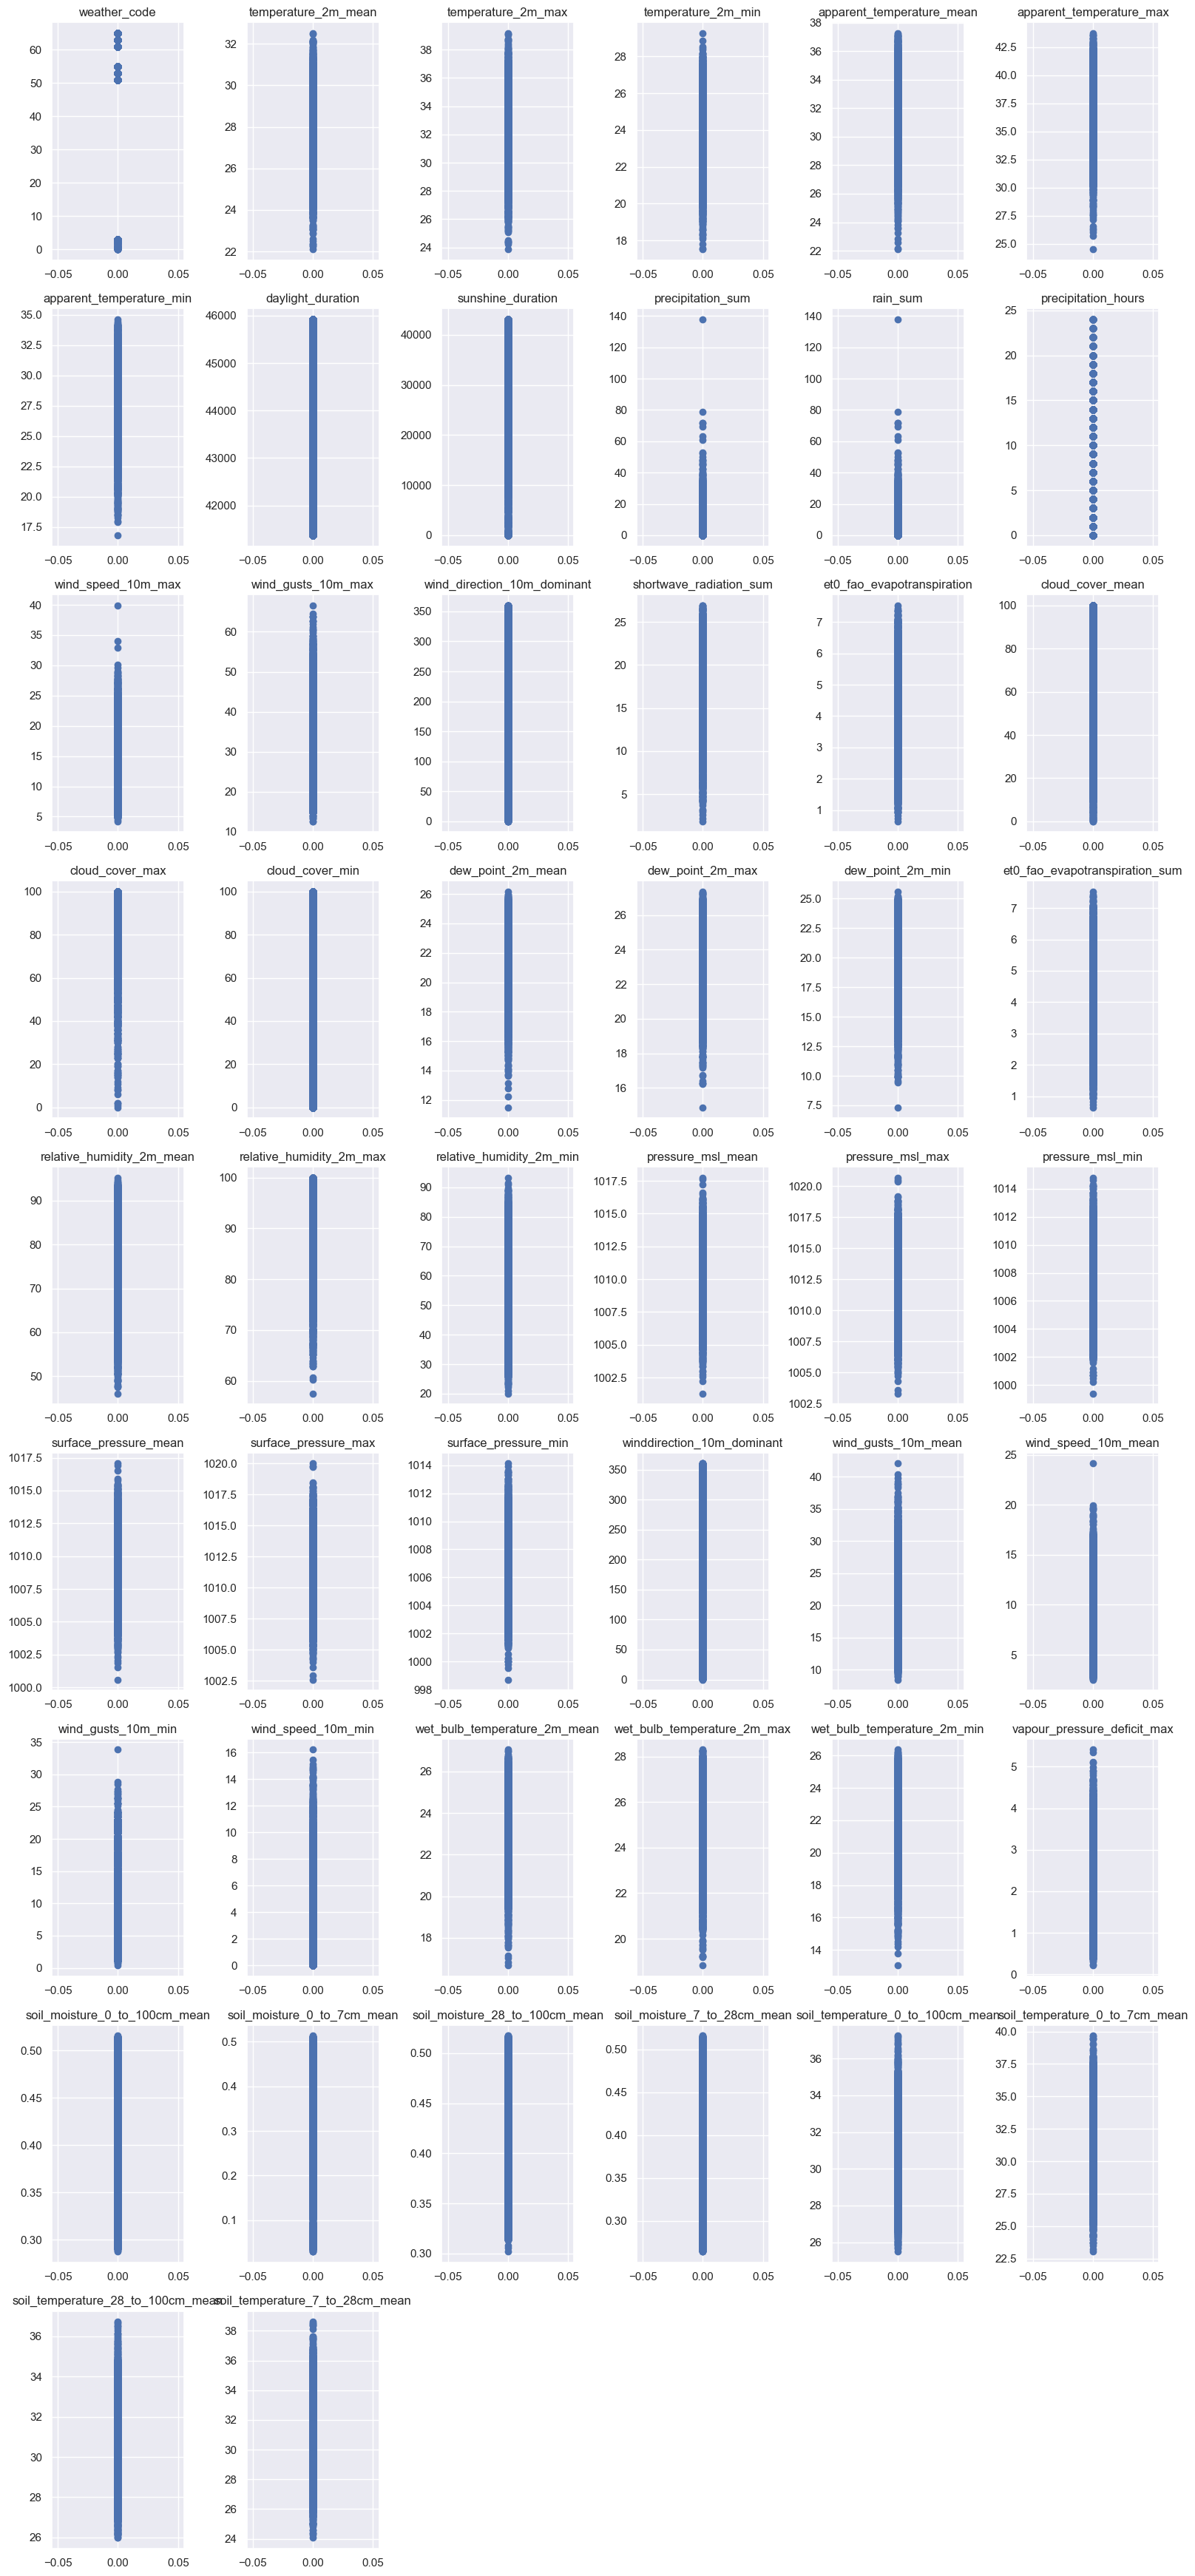

In [ ]:
# Check outlier by visualize method -> quick check
# by each column, values stick together with no outlier is good
visualize_data(data)

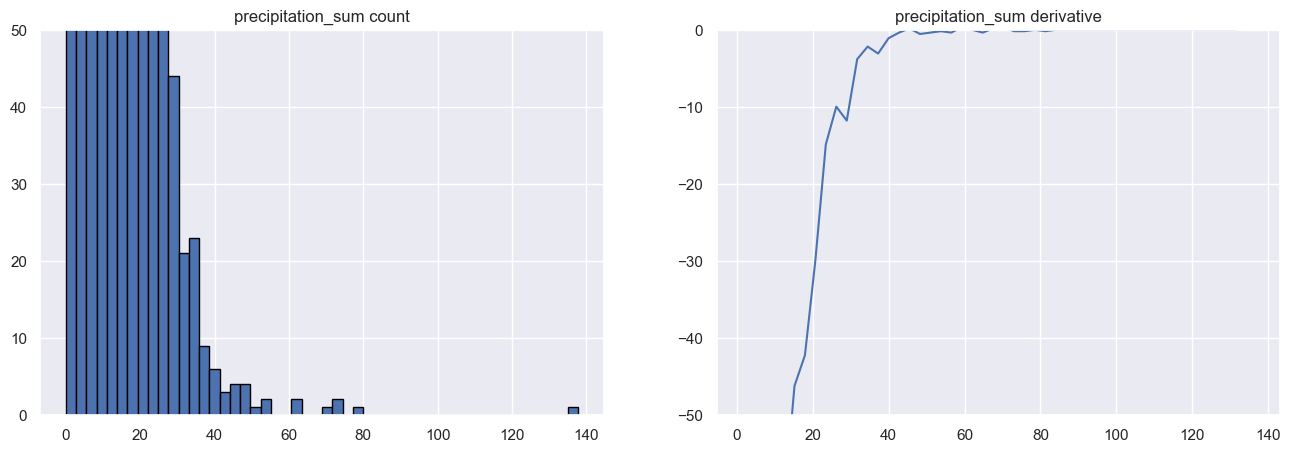

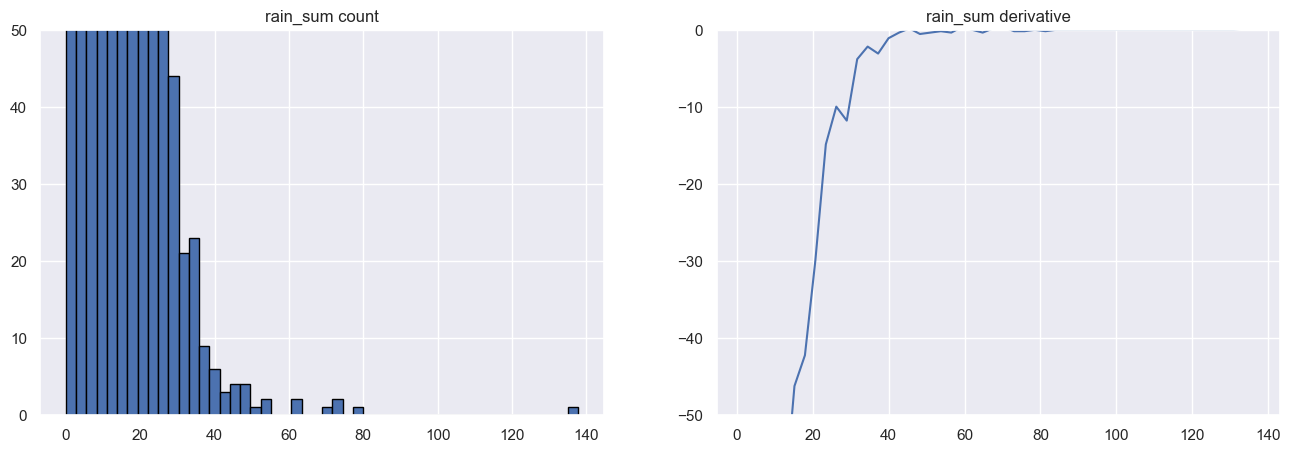

In [26]:
# Các feature nghi ngờ có outlier
inspect = ["precipitation_sum", "rain_sum"]

# Kiểm tra kỹ hơn bằng biểu đồ histogram
for i in range(len(inspect)):
    visualize_histogram(data, inspect[i], 50, -50)

Nhận xét
- Gần như toàn bộ dữ liệu có value dưới 80
- Xuất hiện phần tử có giá trị gần 140 với tỷ lệ xuất hiện cực kỳ thấp
- Trong 1 khoảng giữa cực lớn không xuất hiện điểm dữ liệu nào khác

Kết luận:
- precipitation_sum, rain_sum tồn tại outlier cần loại bỏ

Giải pháp:
- Thay giá trị outlier bằng median ?
- Xóa dòng có outlier ?                 <- chọn

In [27]:
# Xóa outlier

# Condition to remove
condition = (data['precipitation_sum'] > 100) | (data['rain_sum'] > 100)

# Get the index of rows satisfying the condition
rows_to_drop_index = data[condition].index

# Drop the rows
data.drop(rows_to_drop_index, inplace=True)

print(f"drop {len(rows_to_drop_index)} row")

drop 1 row


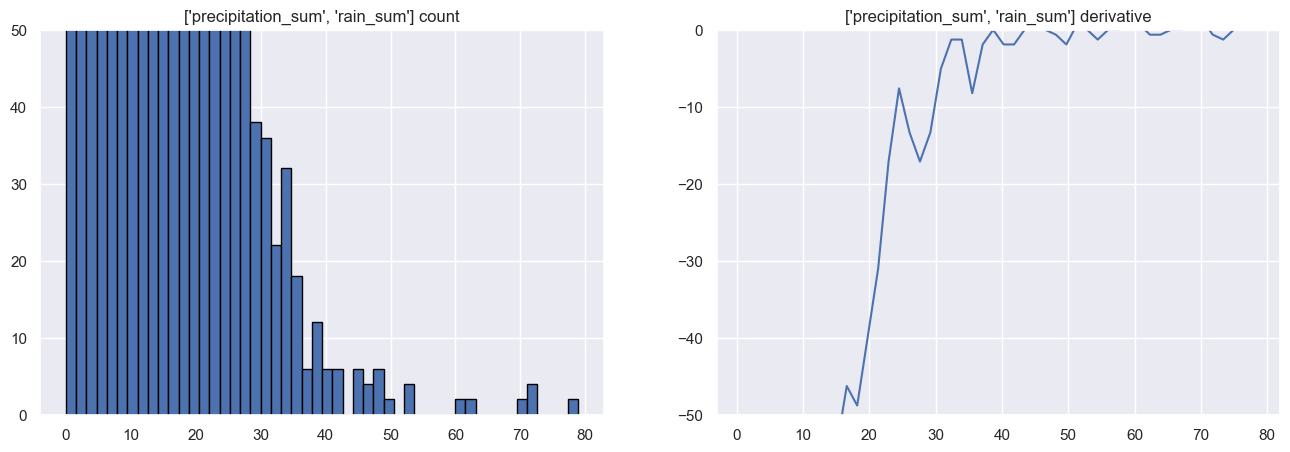

In [28]:
# Kiểm tra lại sau khi xử lý bằng biểu đồ histogram
inspect = ["precipitation_sum", "rain_sum"]
visualize_histogram(data, inspect, 50, -50)

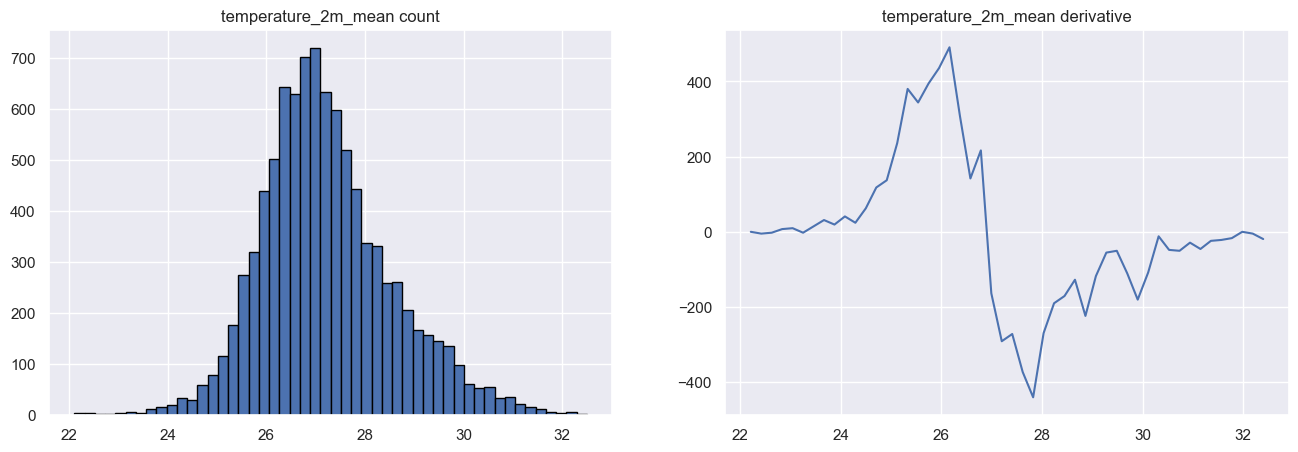

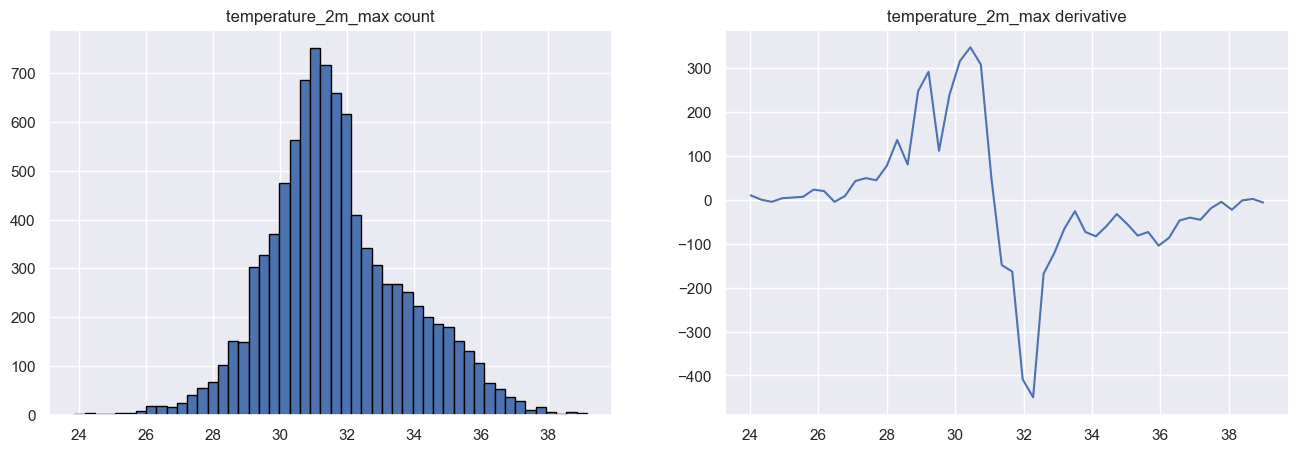

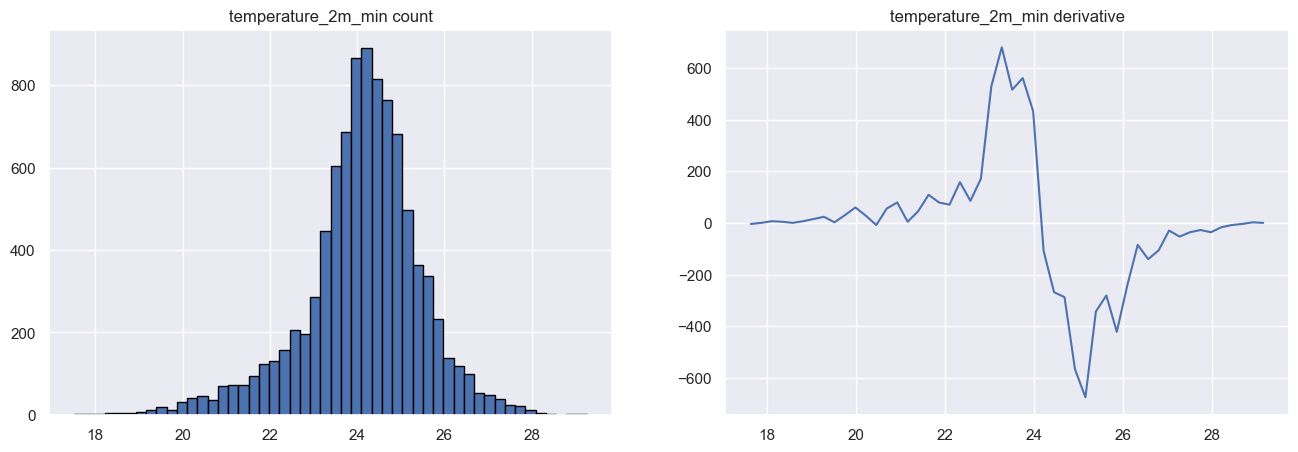

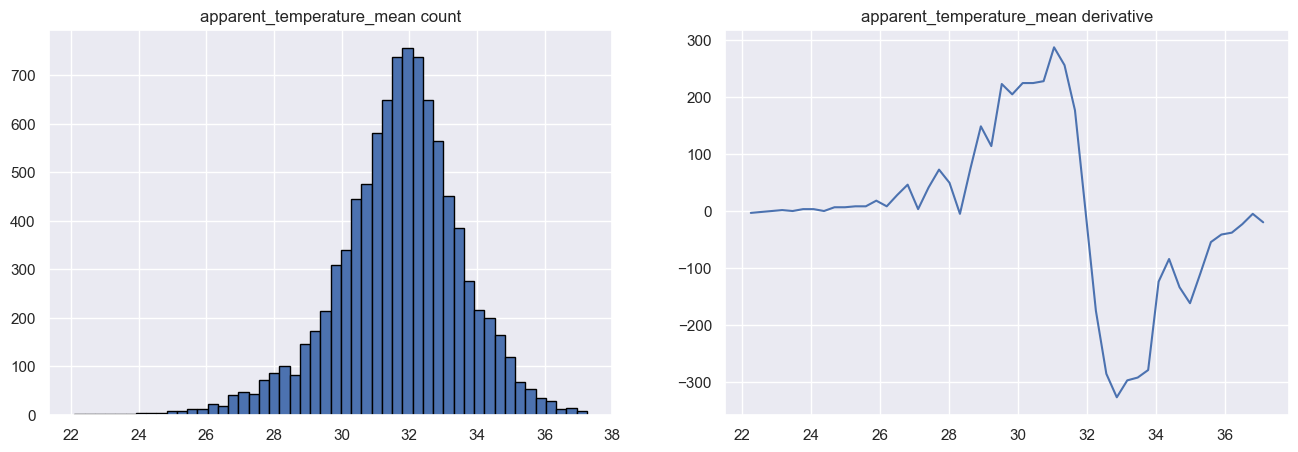

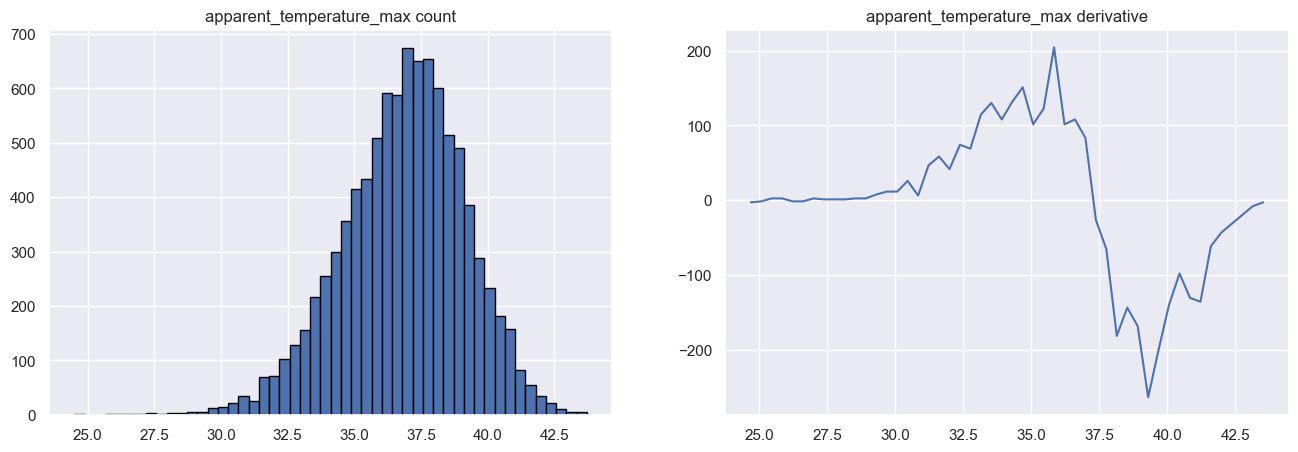

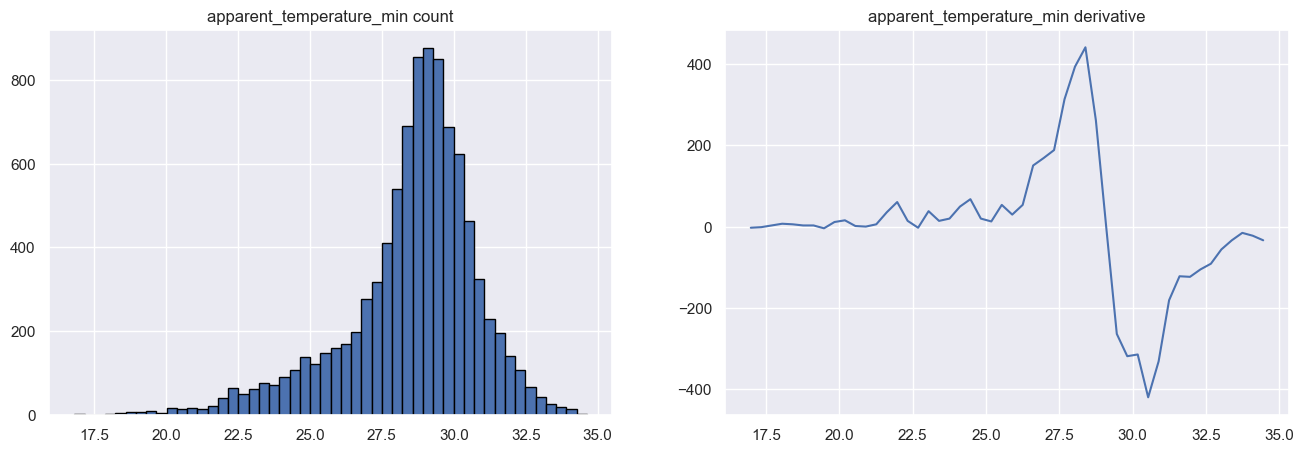

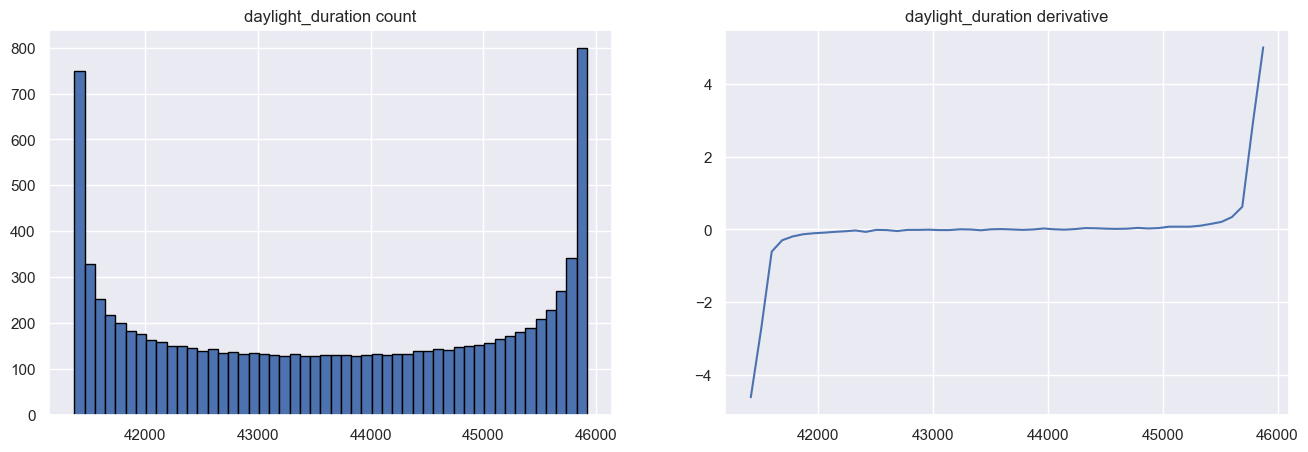

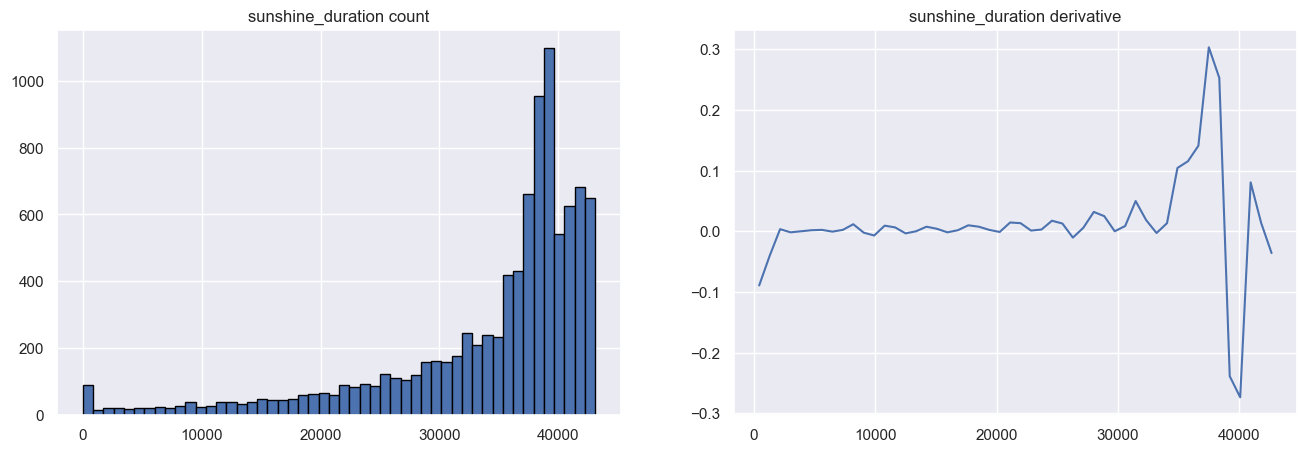

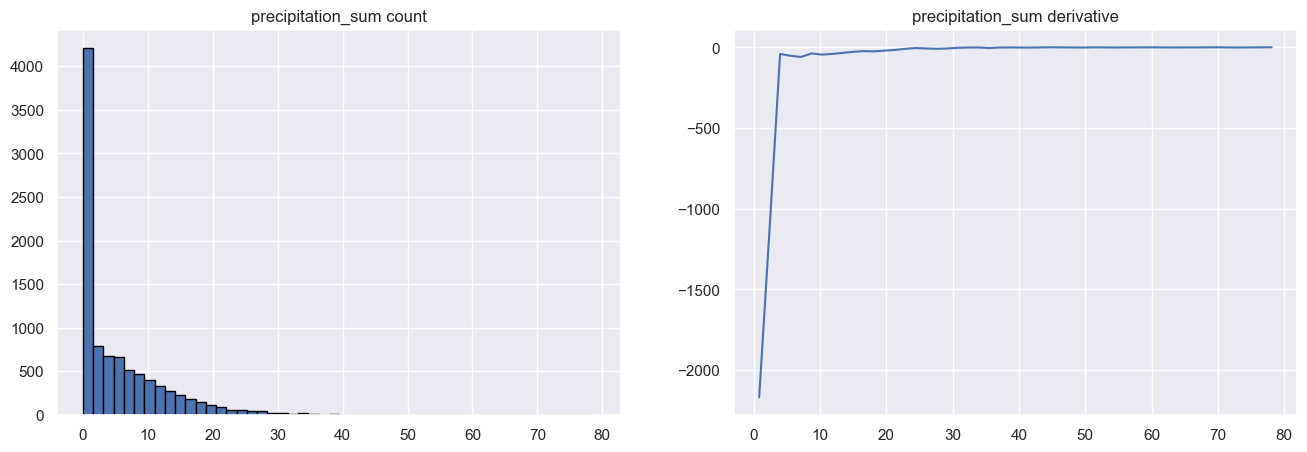

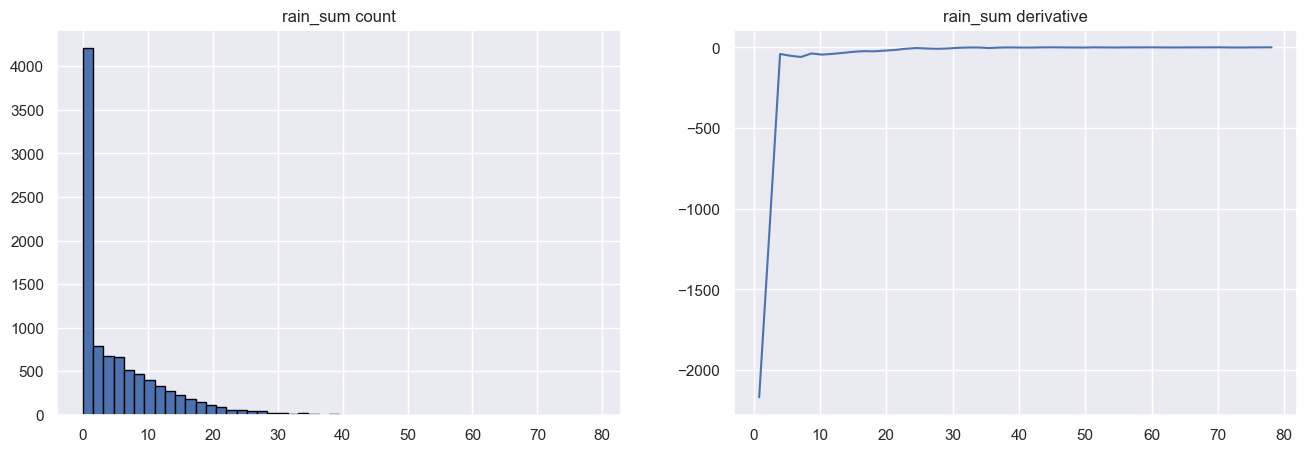

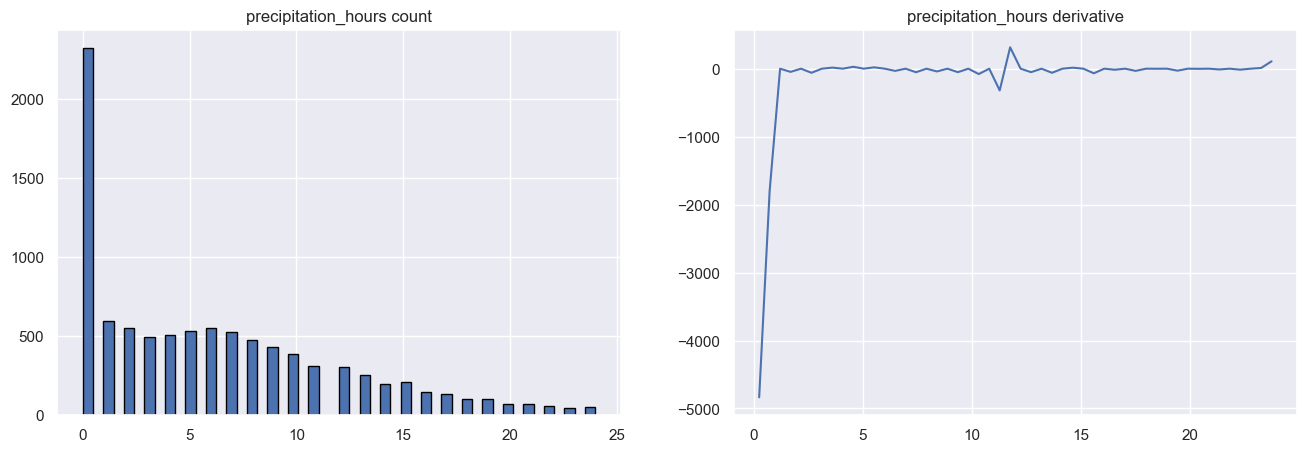

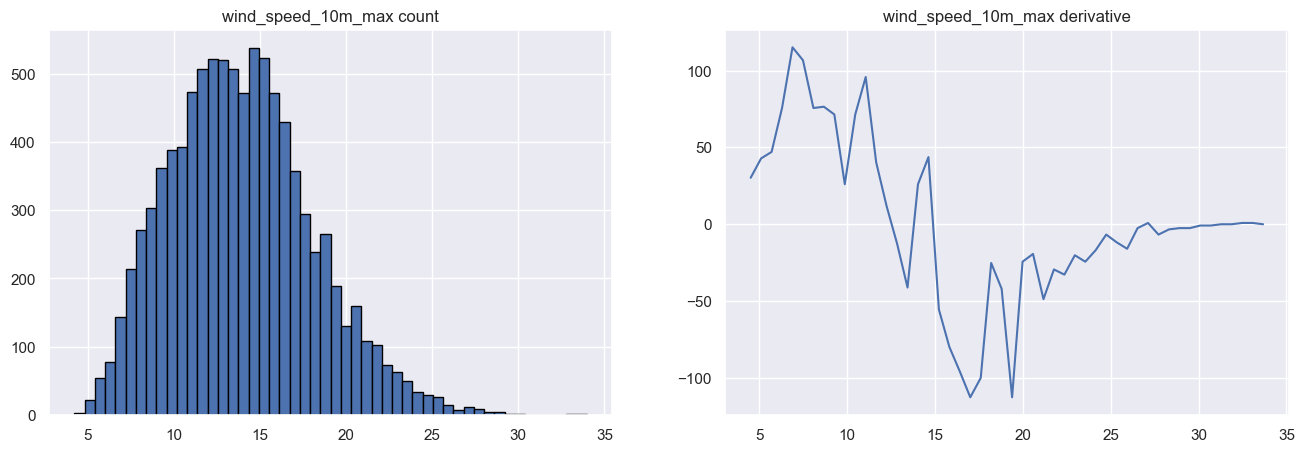

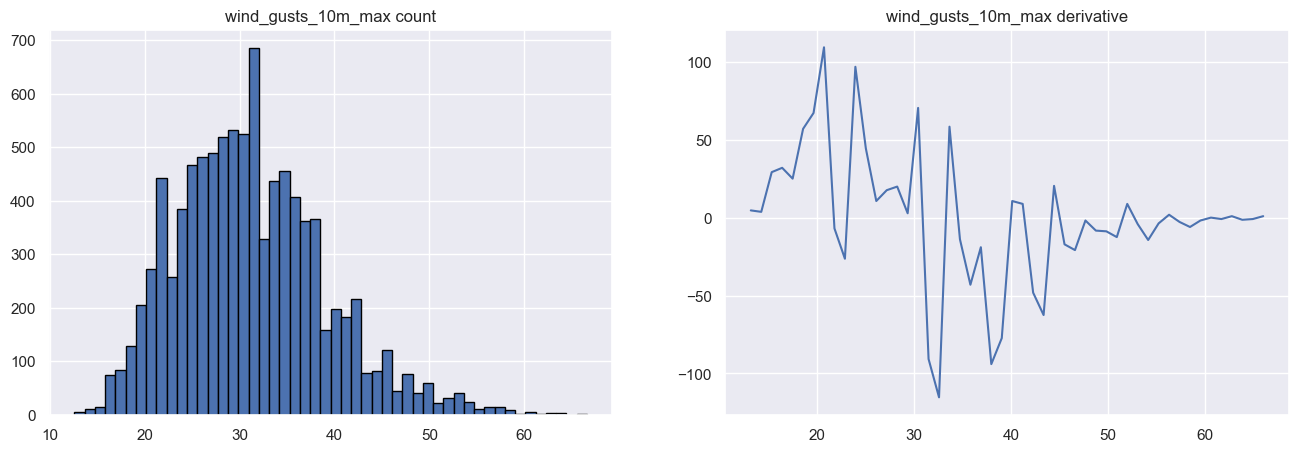

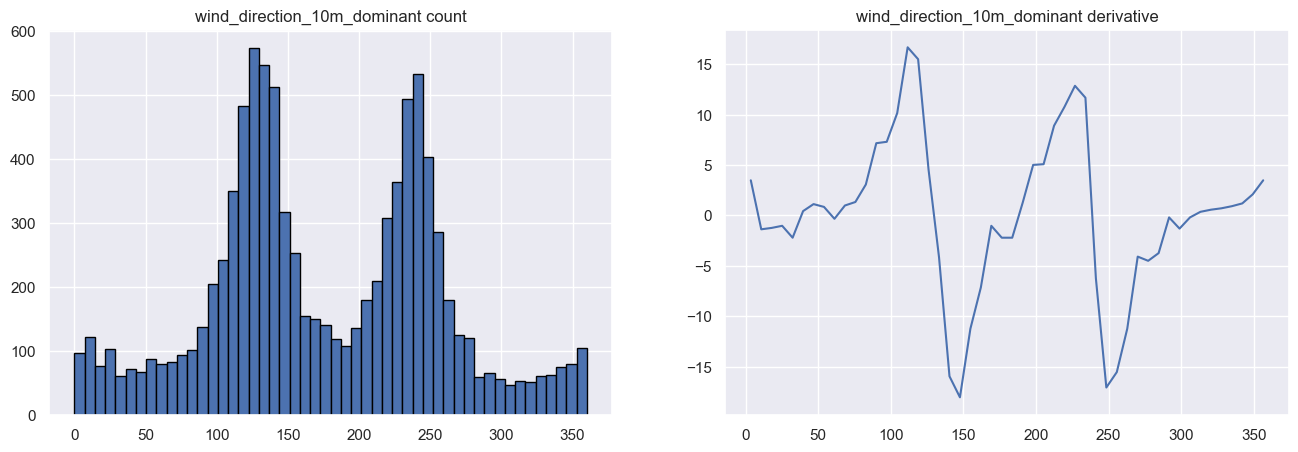

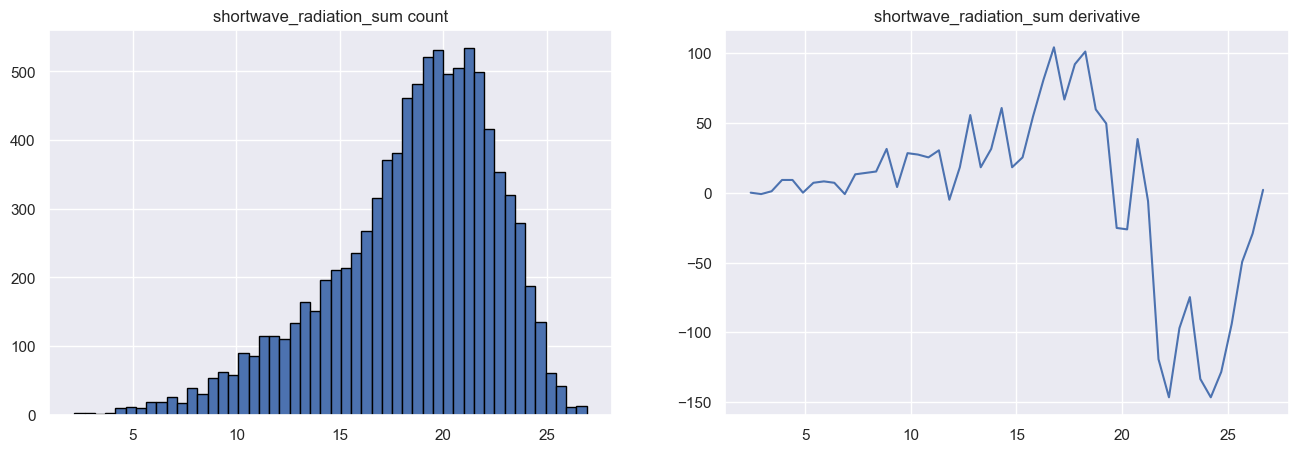

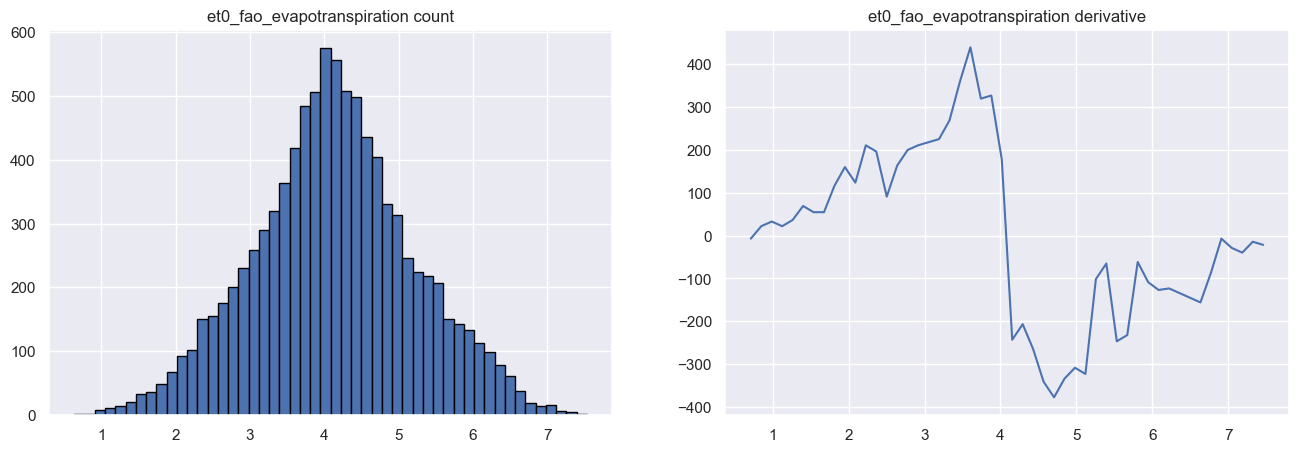

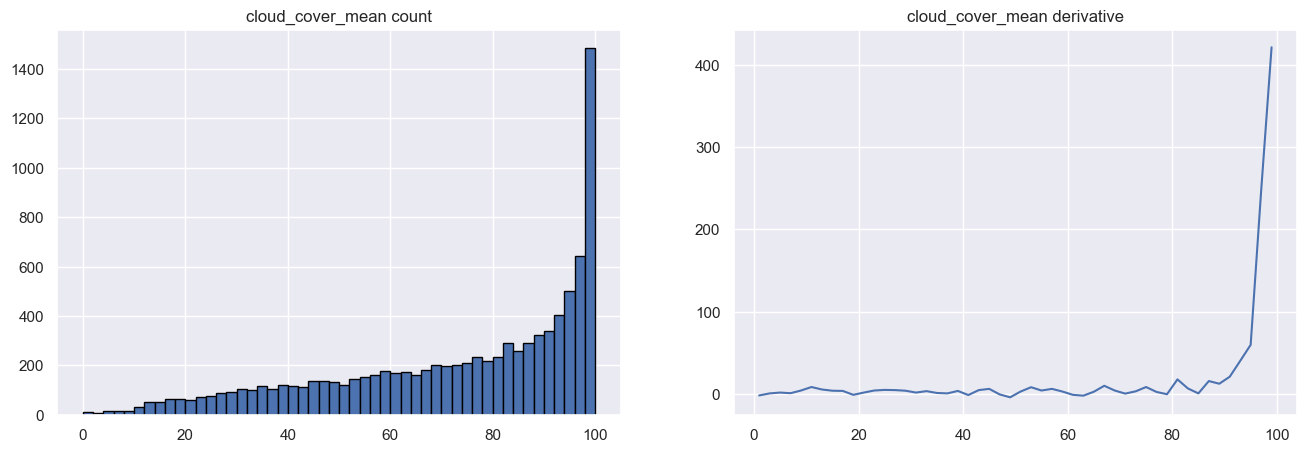

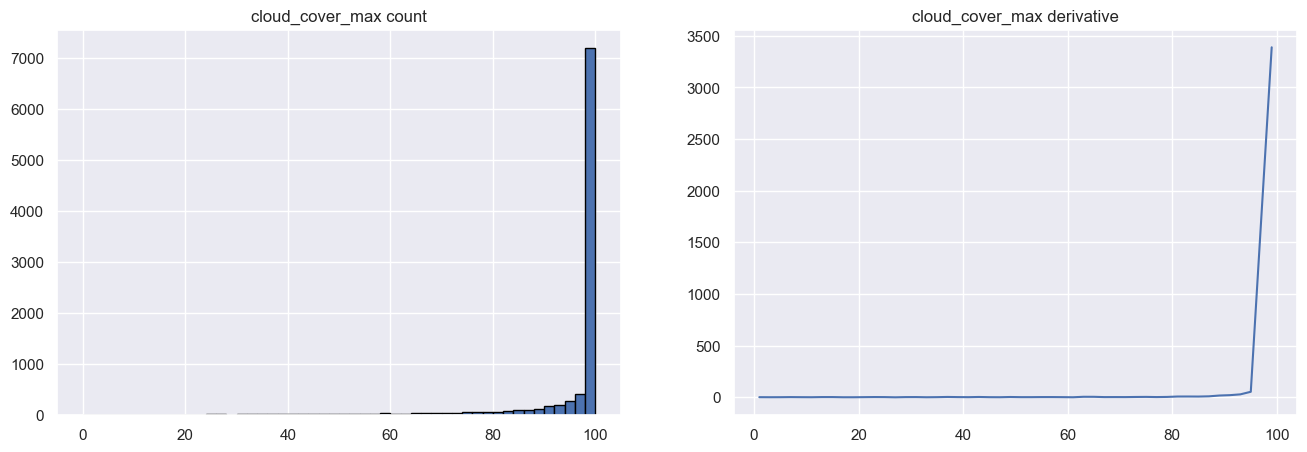

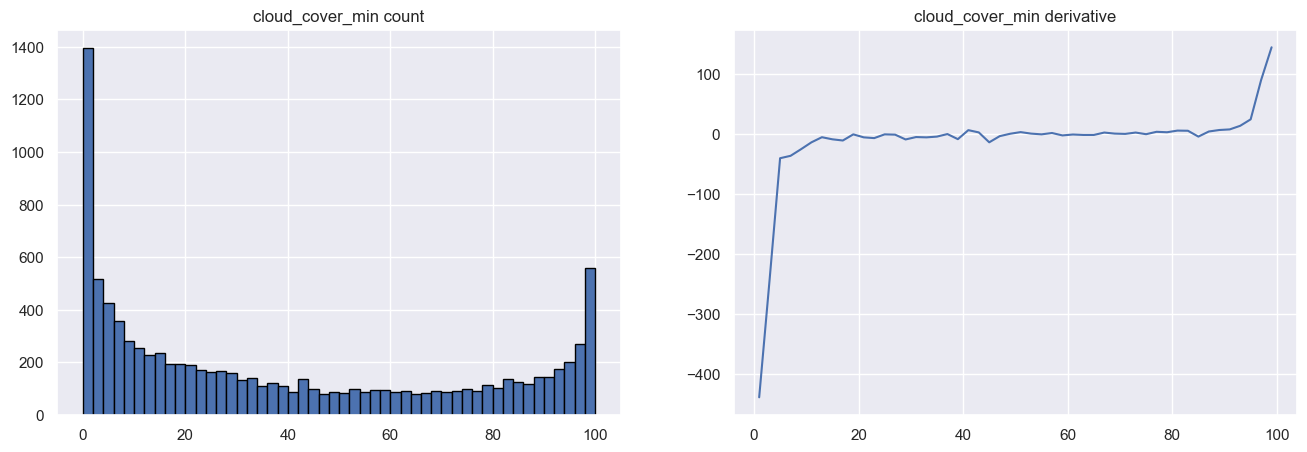

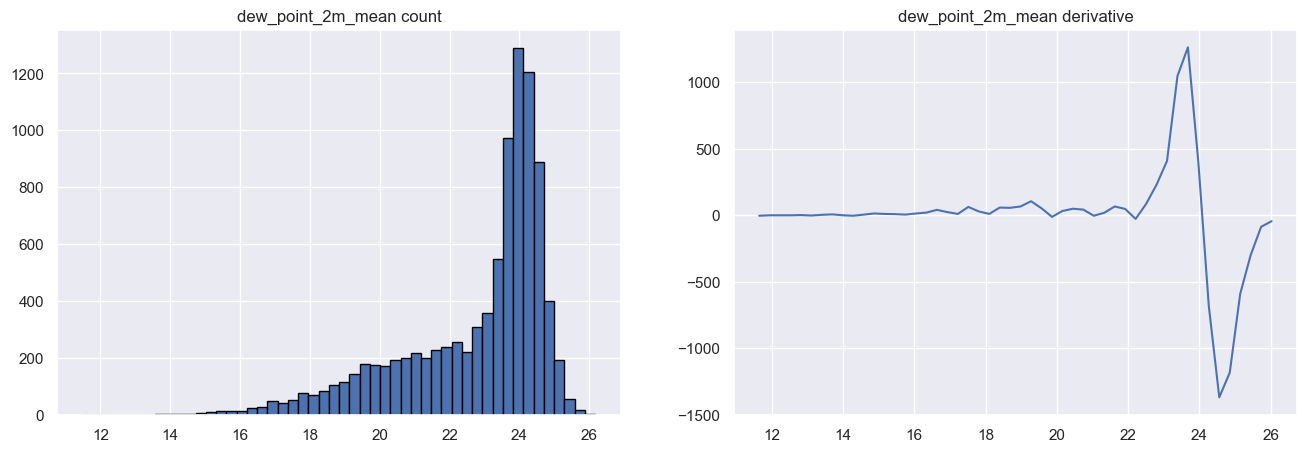

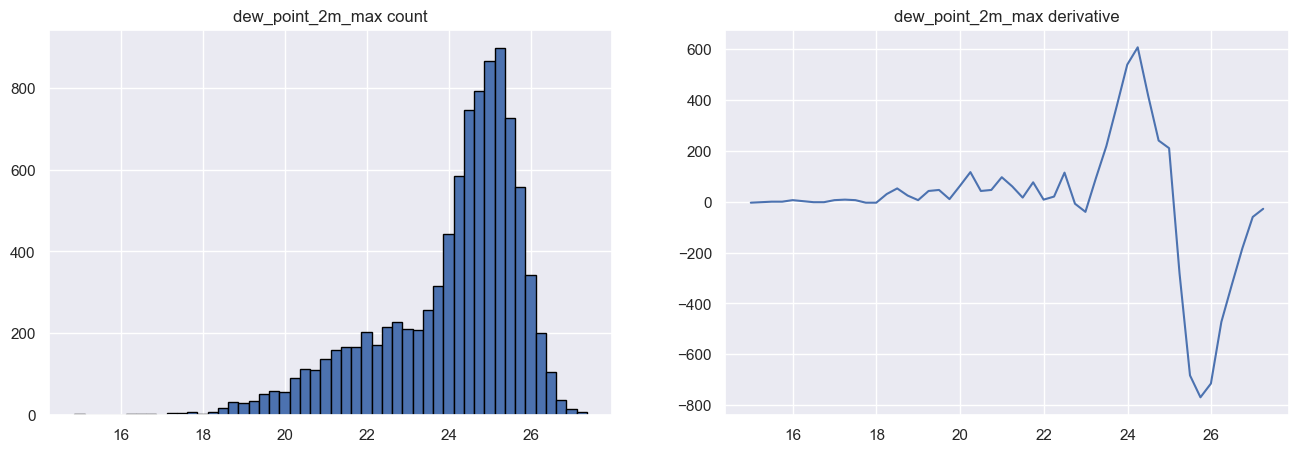

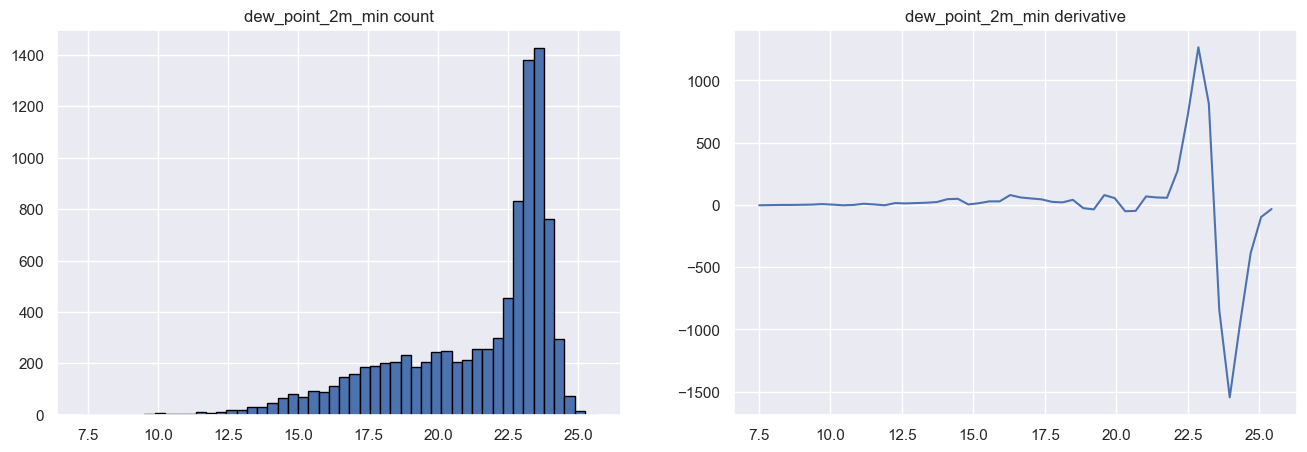

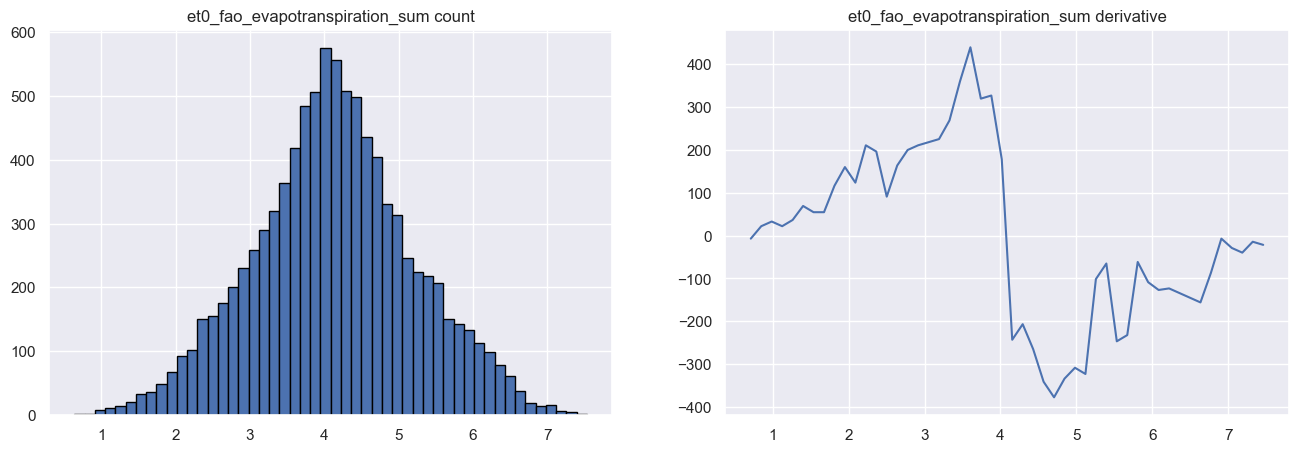

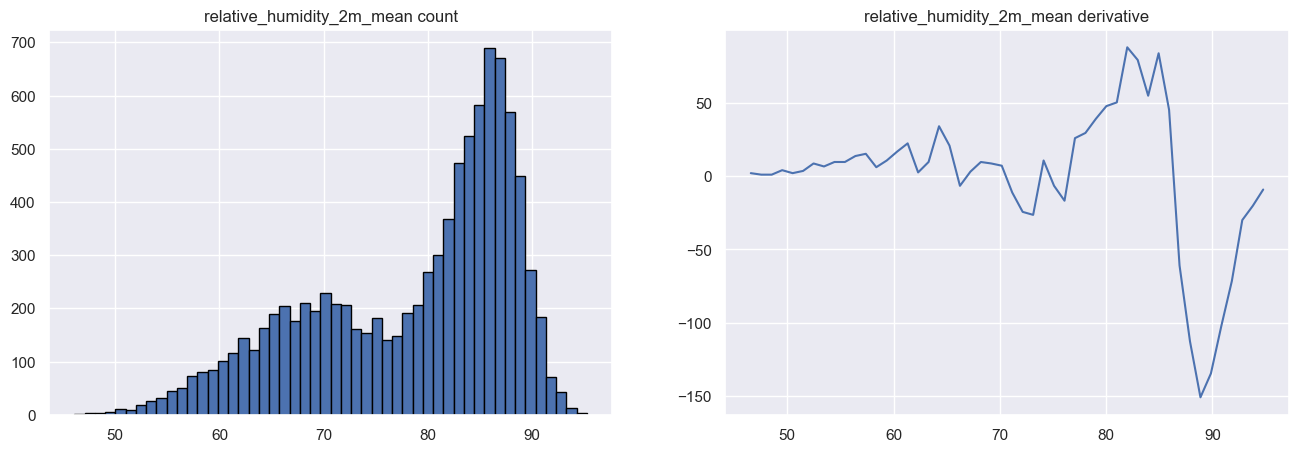

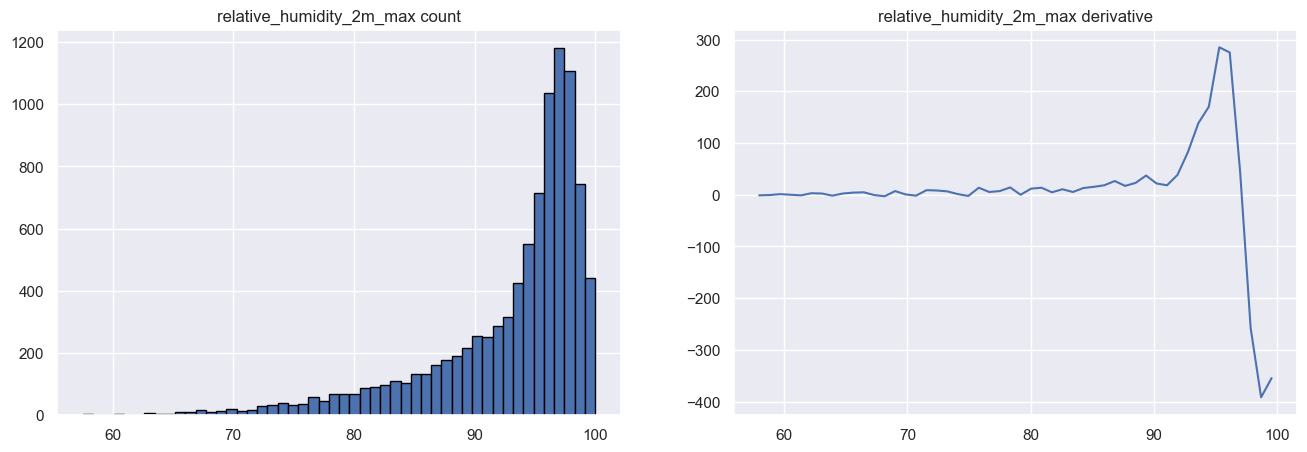

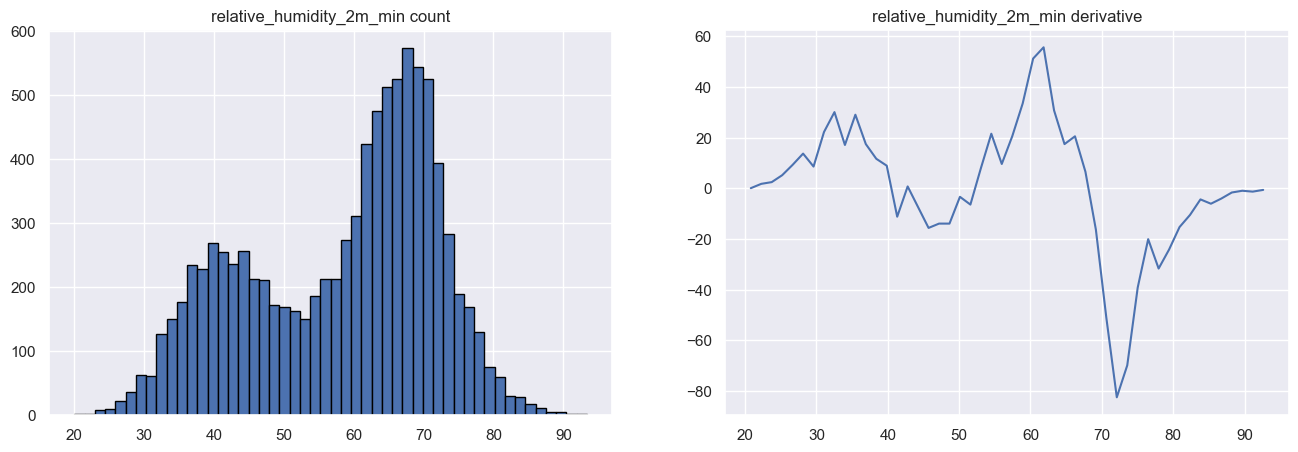

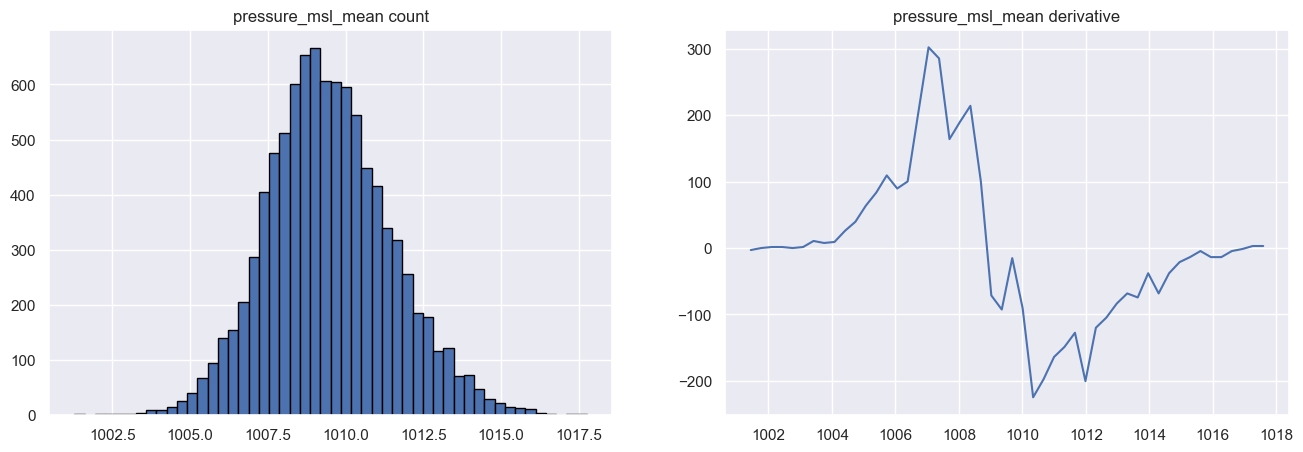

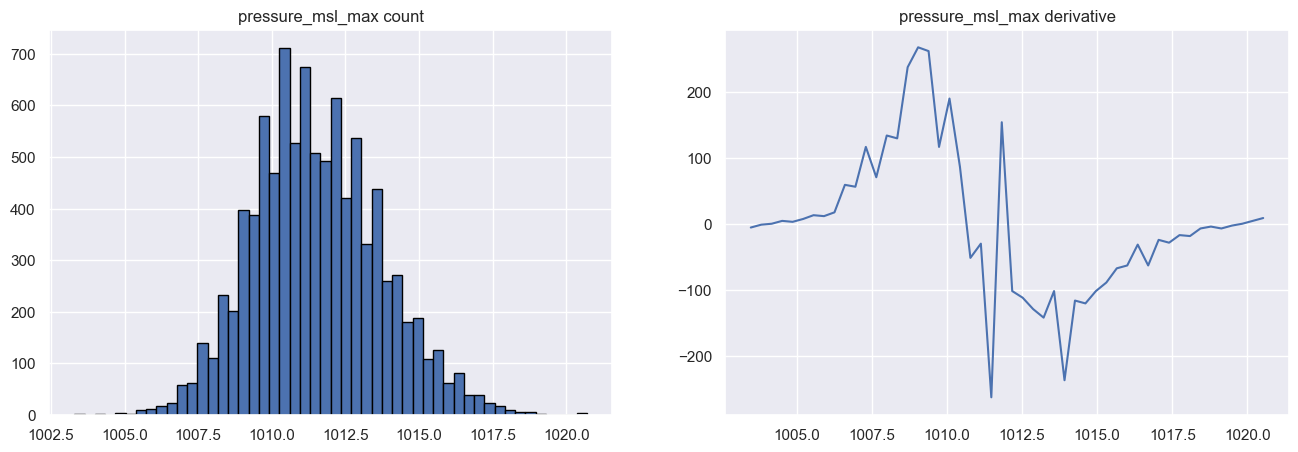

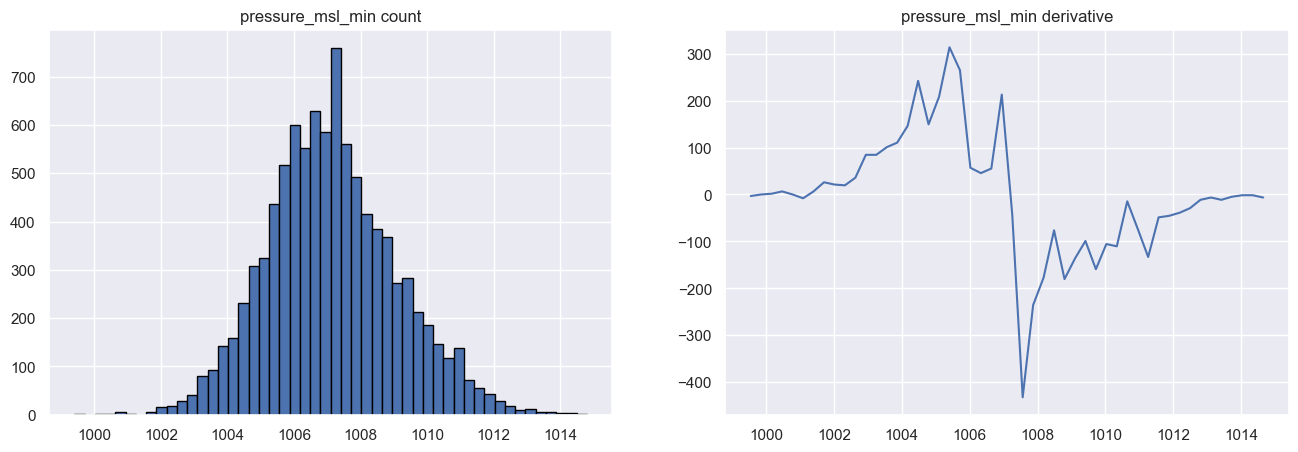

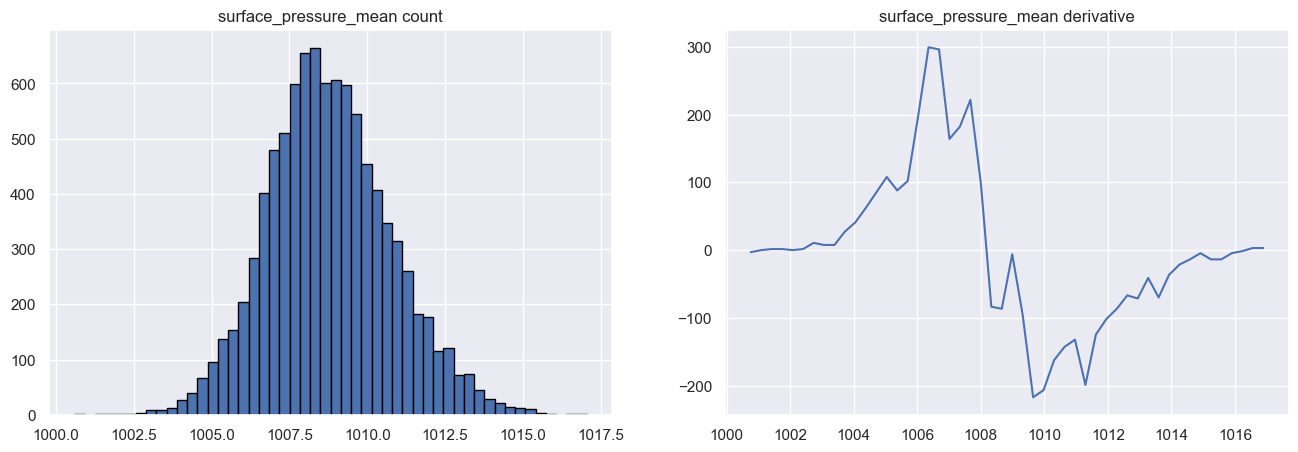

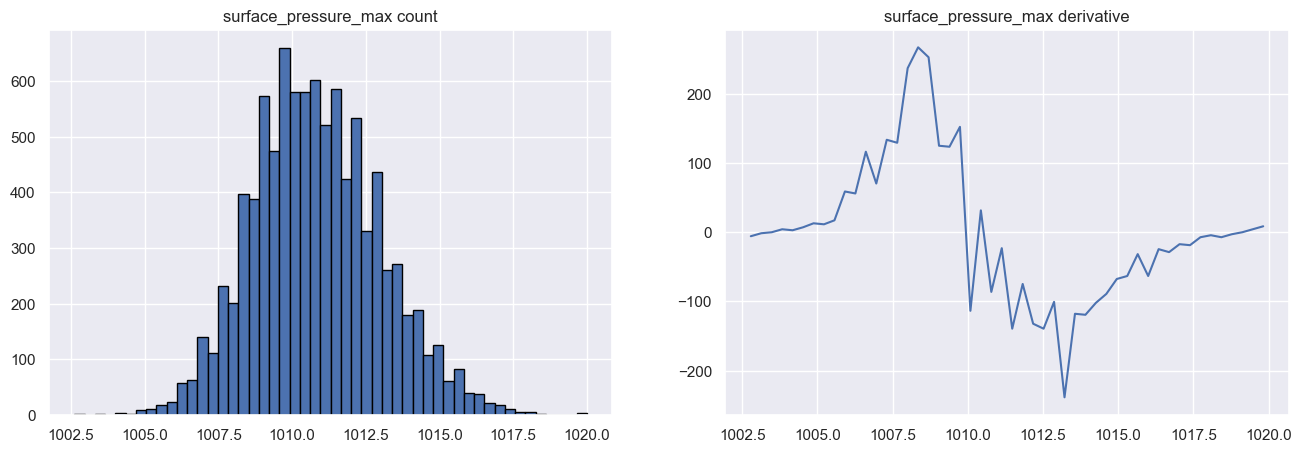

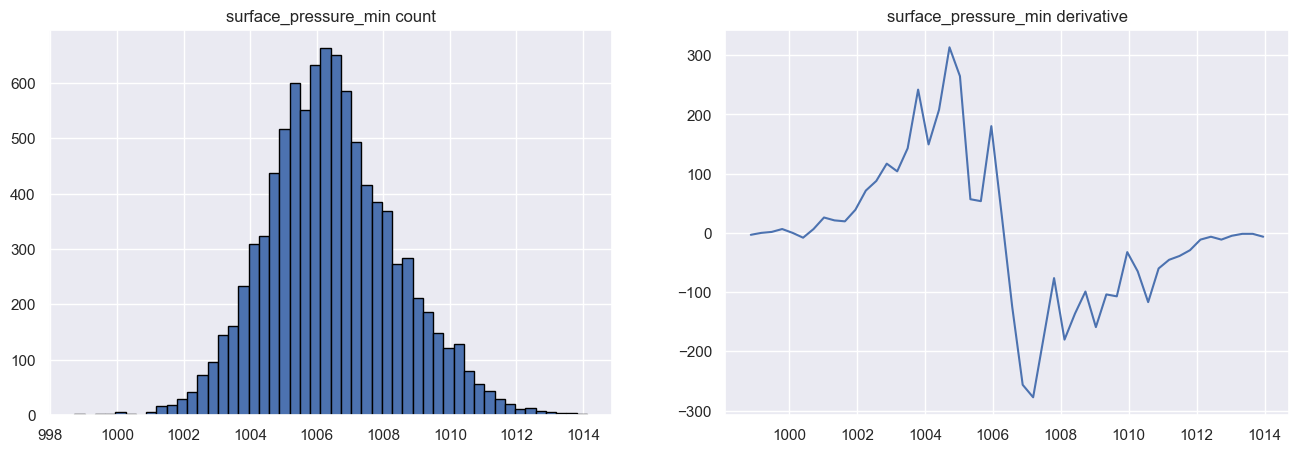

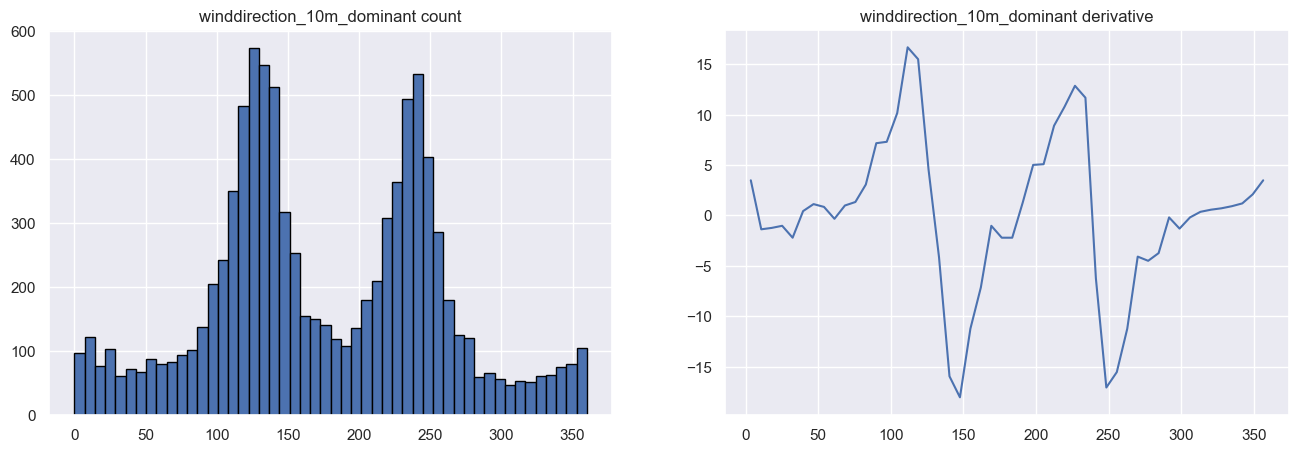

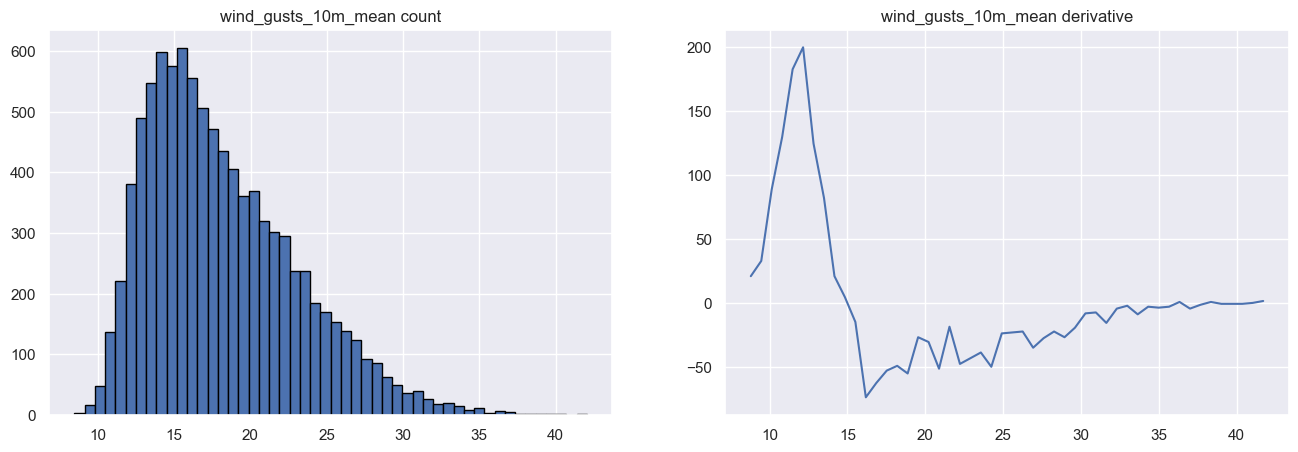

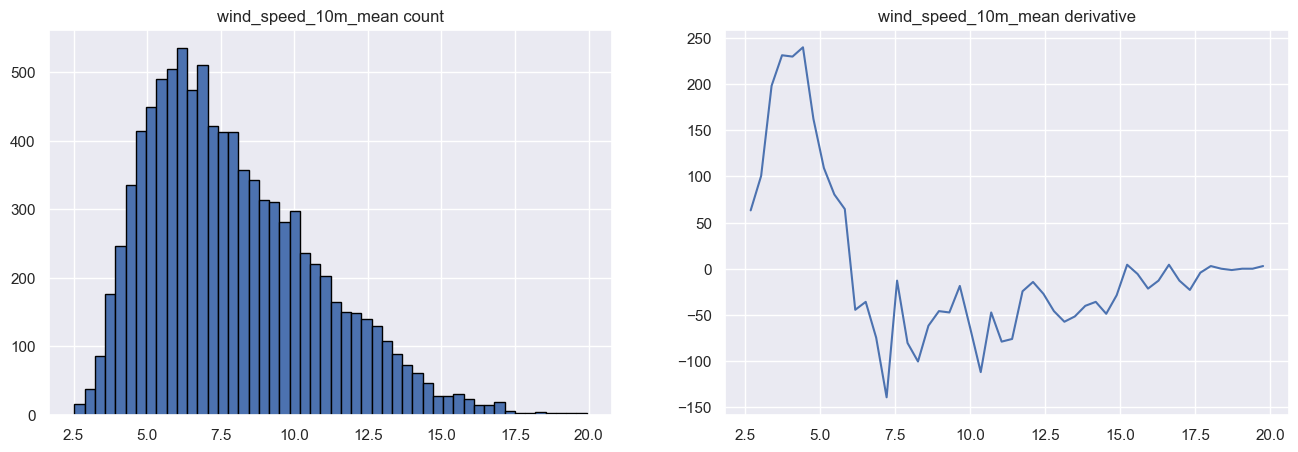

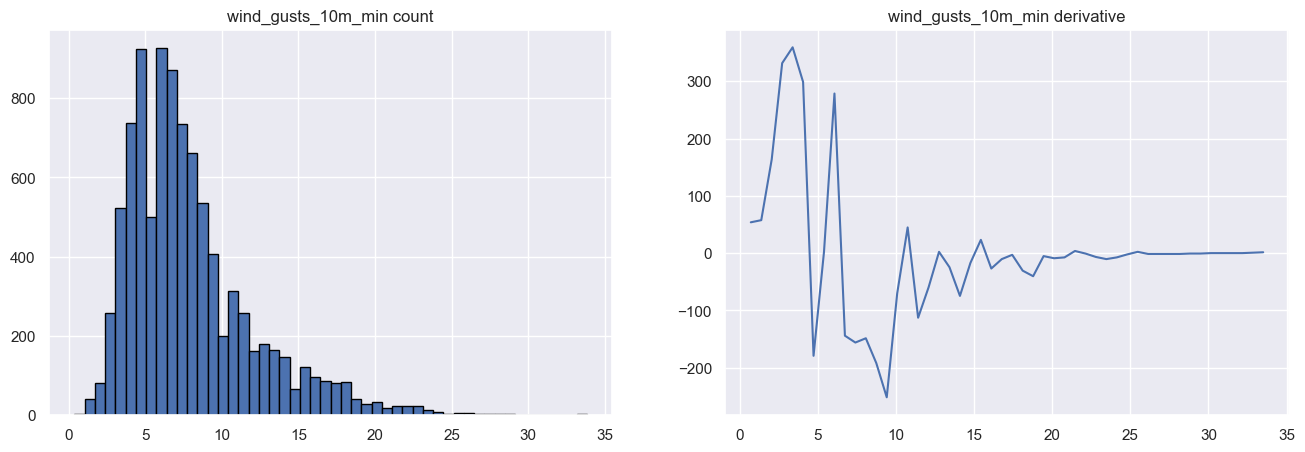

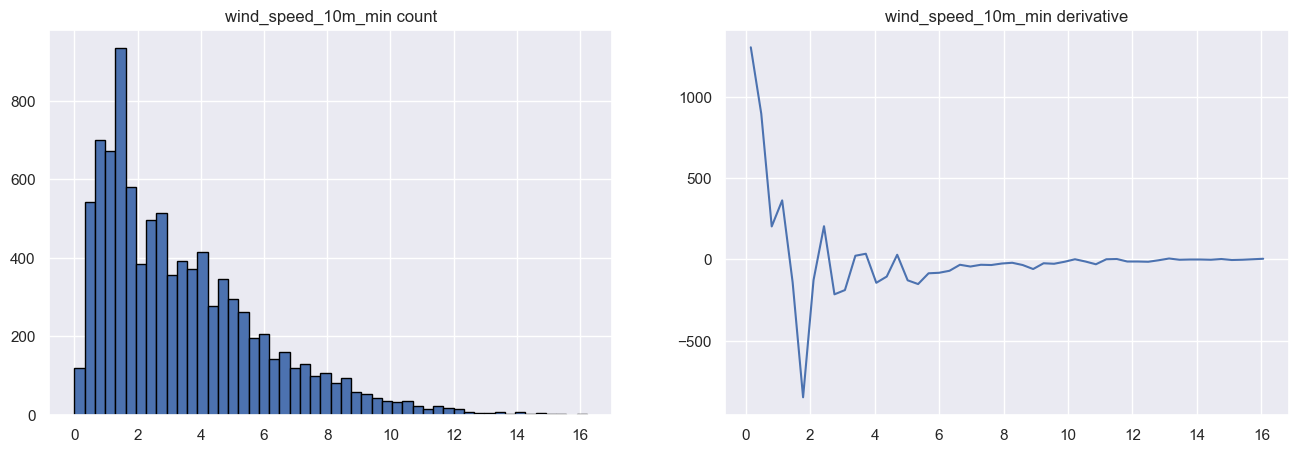

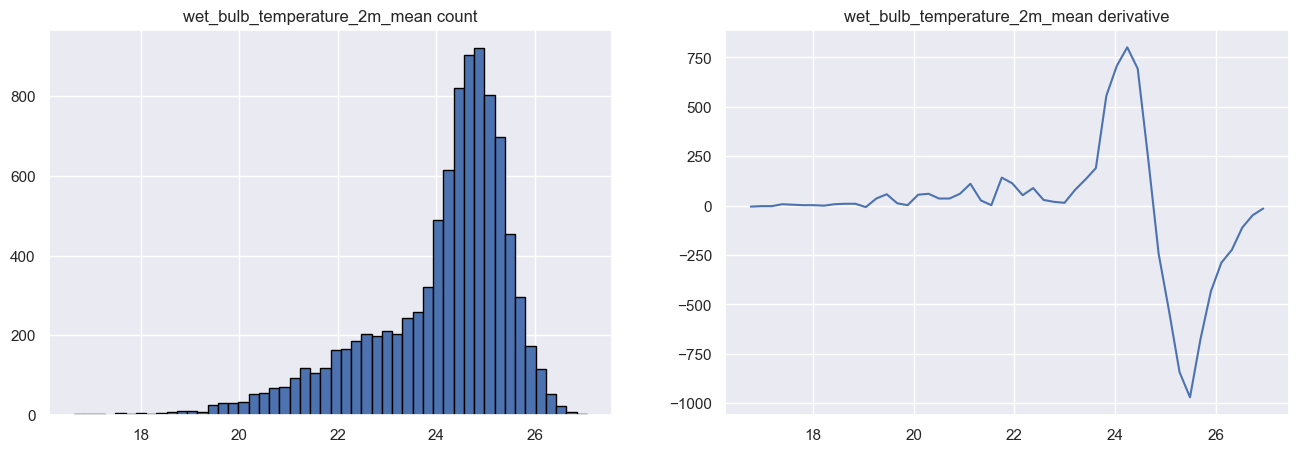

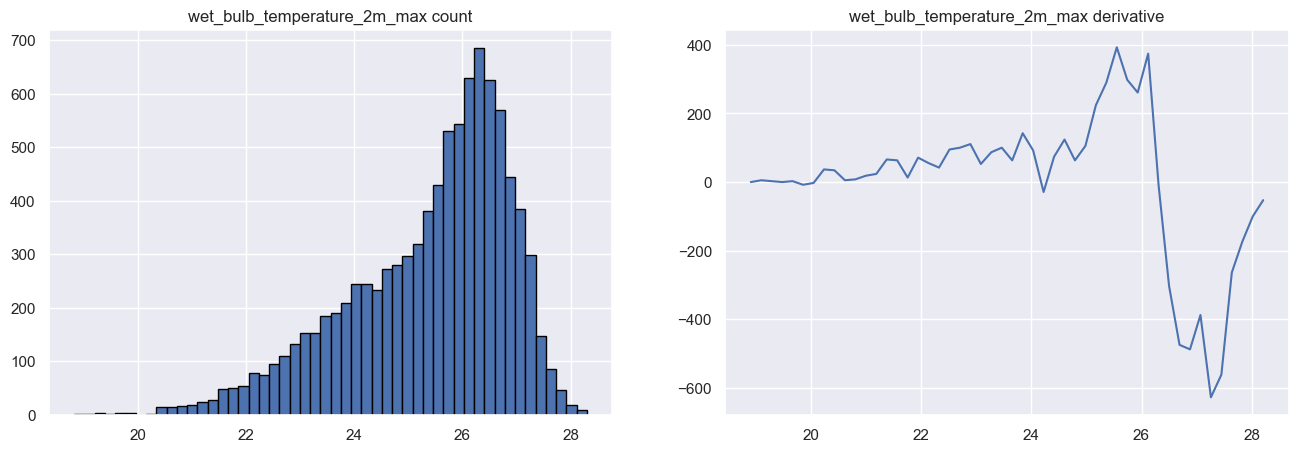

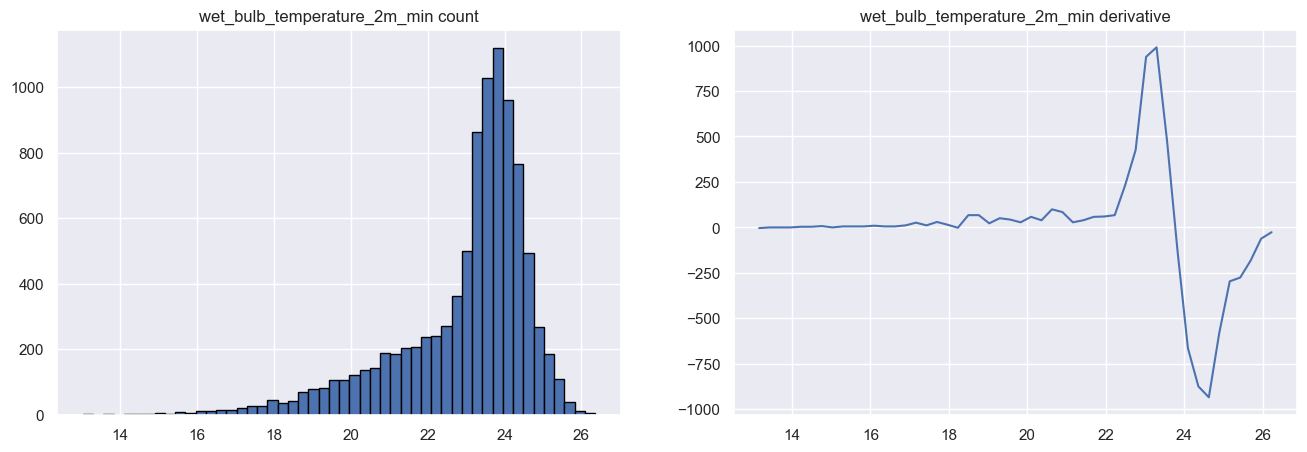

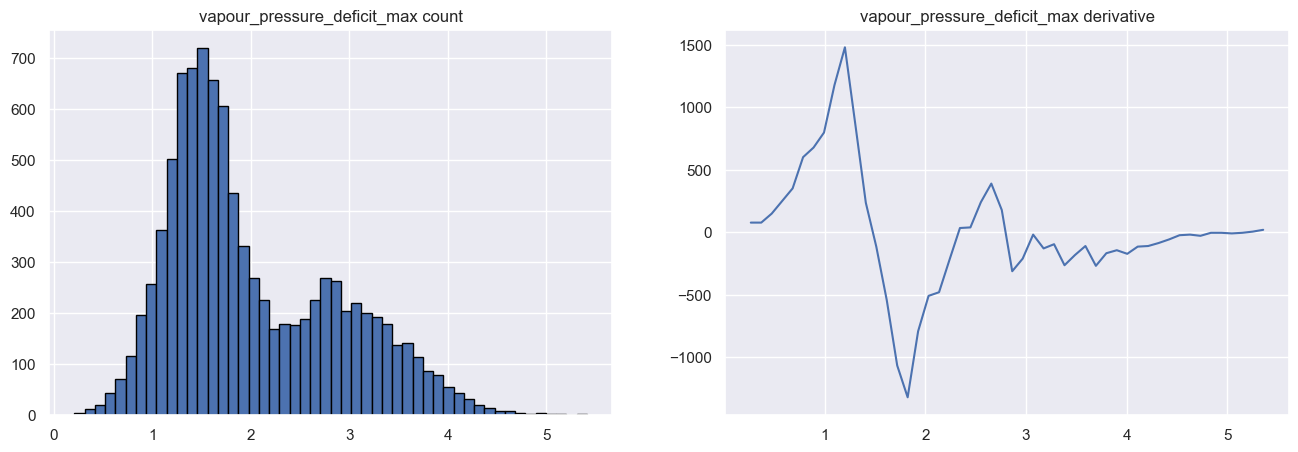

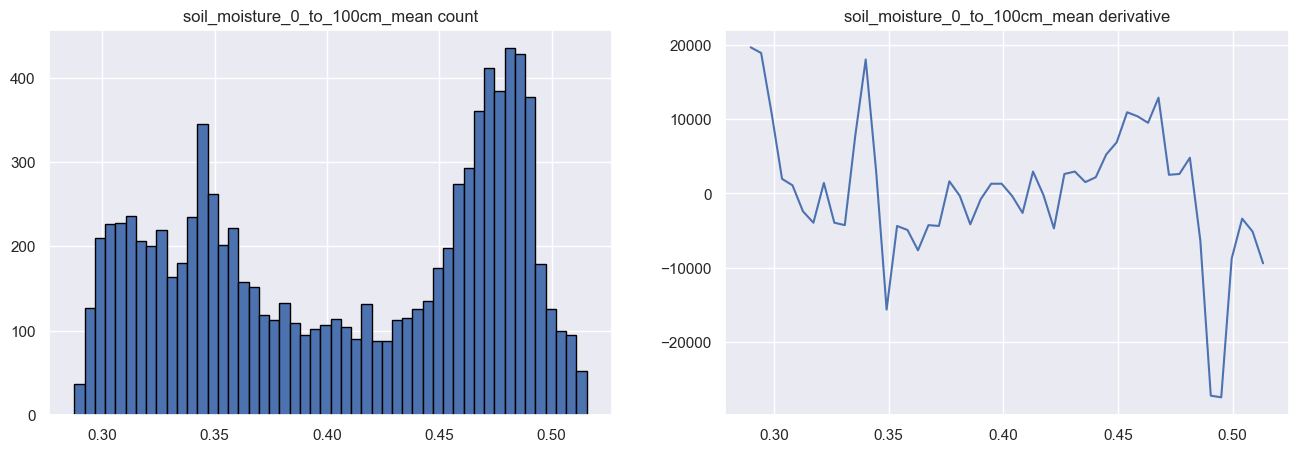

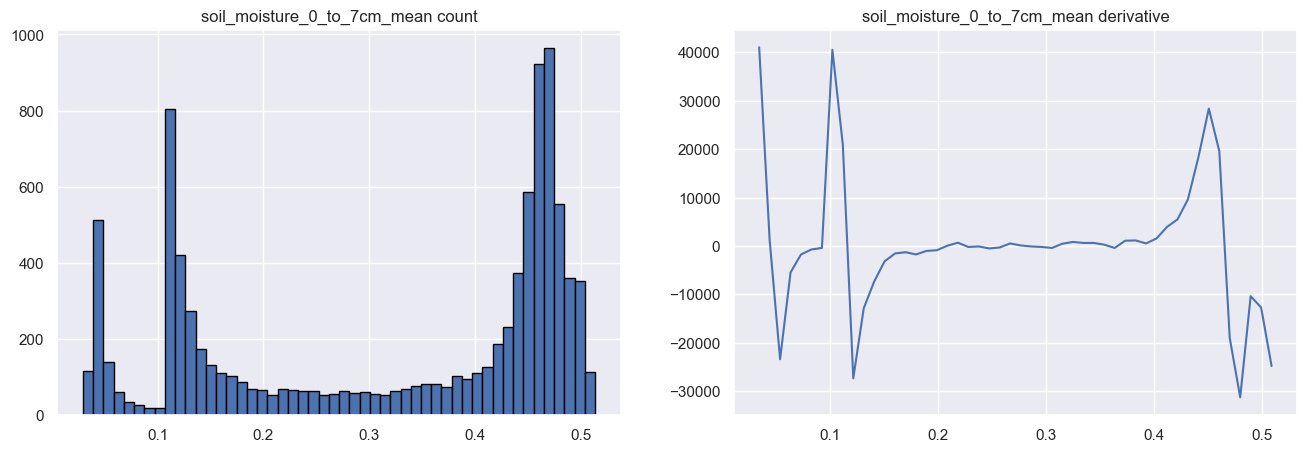

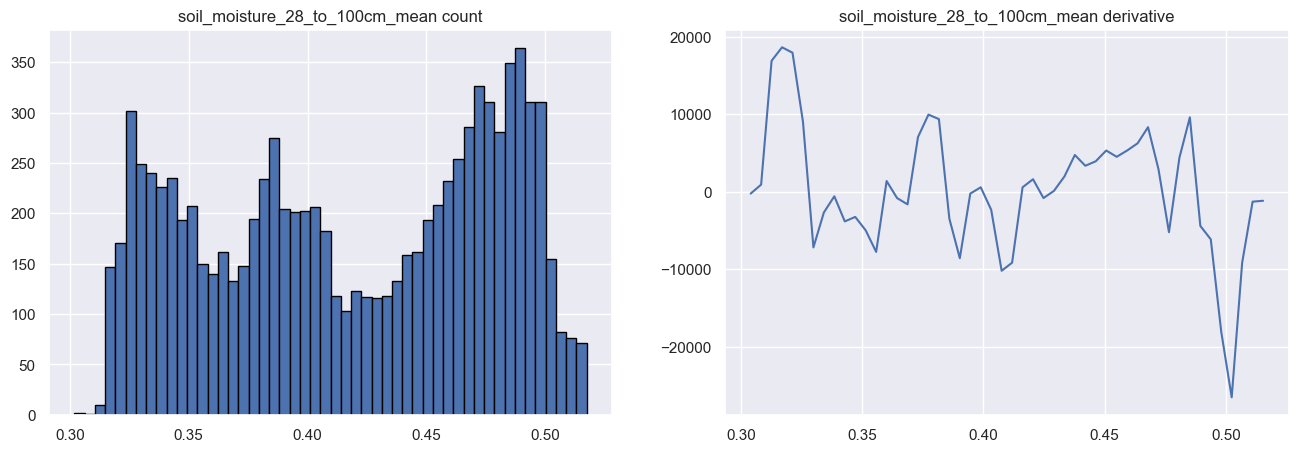

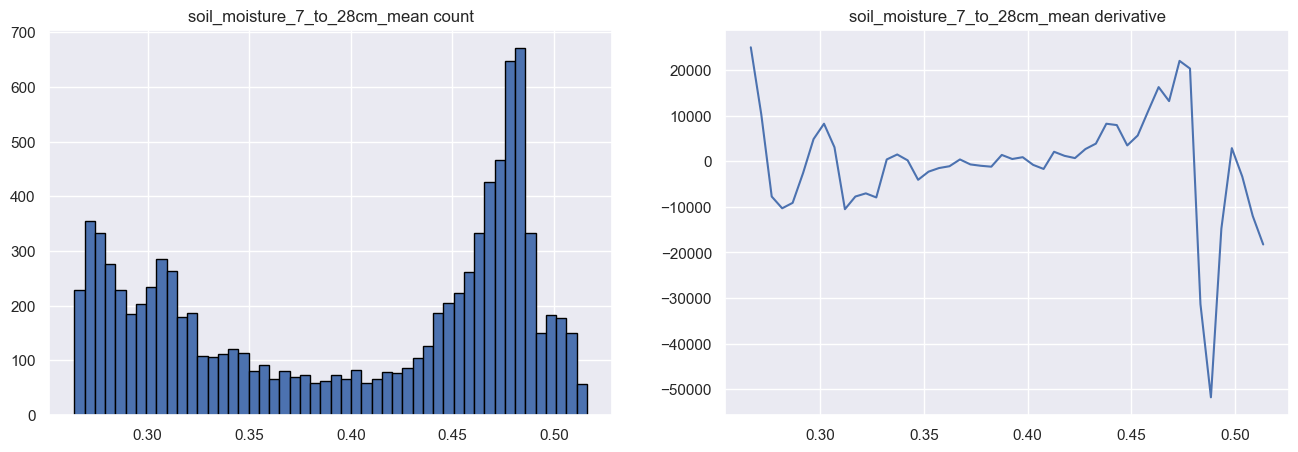

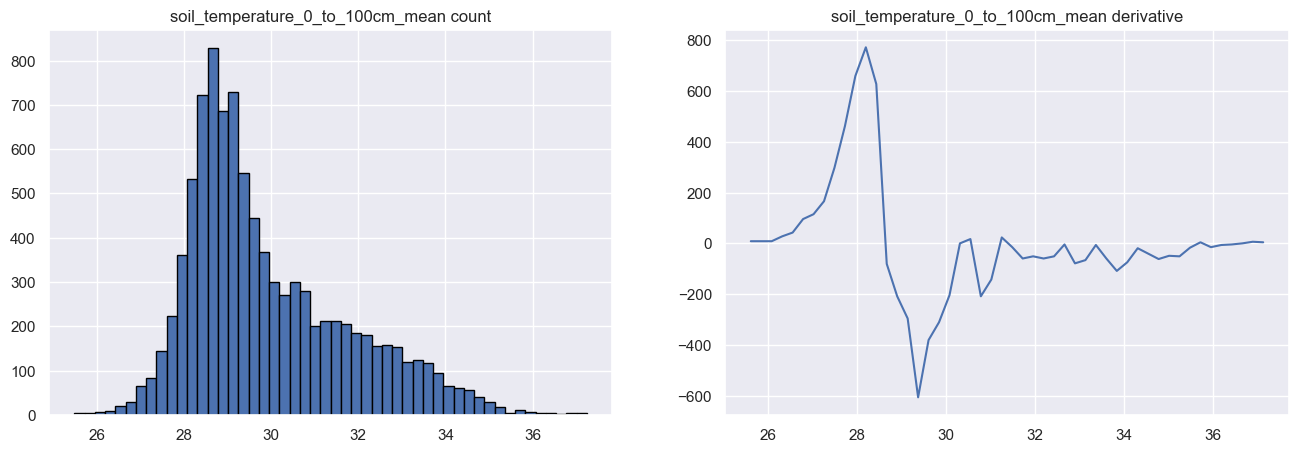

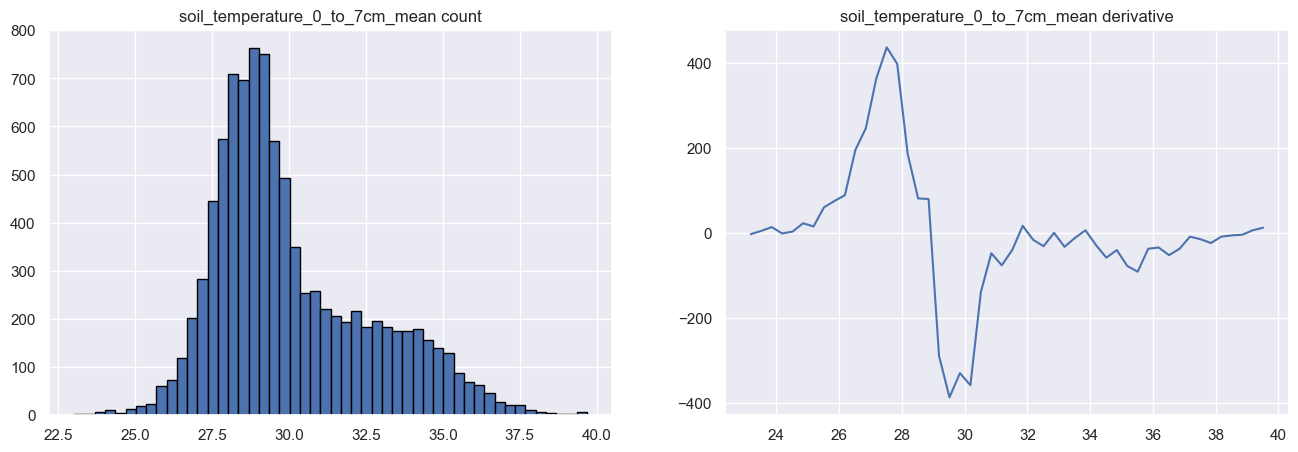

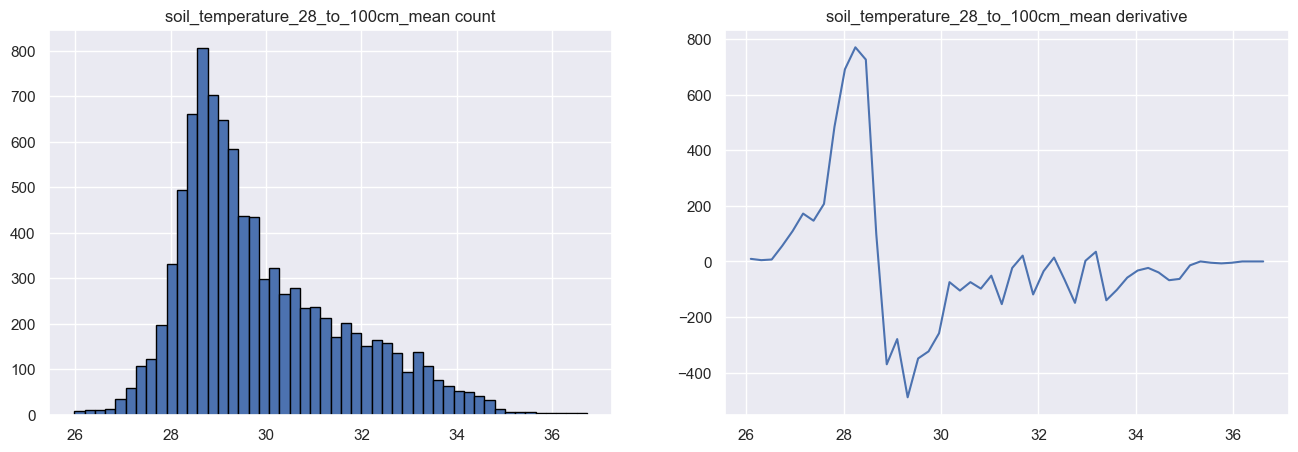

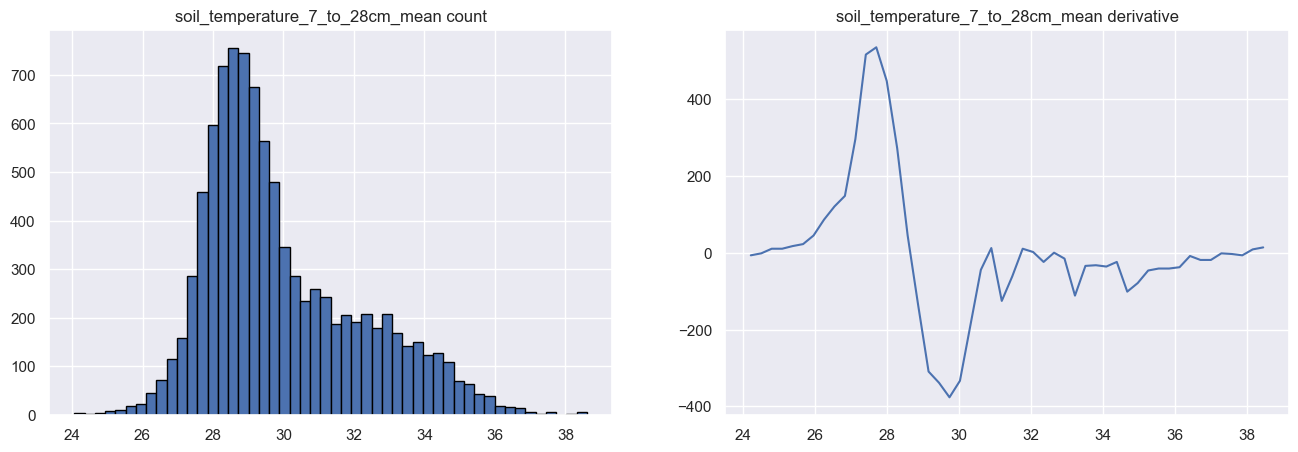

In [29]:
# Xem lại histogram của toàn bộ dữ liệu (bỏ cột đầu)
for col in range(1, data.columns.size):
    visualize_histogram(data, data.columns[col])

In [30]:
data.to_csv('open-meteo.clean.csv', index=False) 